In [1]:
import os
import time
import h5py
import glob
import numpy as np
import xarray as xr

import pandas as pd
import geopandas as gpd

from datetime import datetime

import scipy.stats as stats
from scipy.stats import linregress
from scipy.stats import weibull_min
from scipy.interpolate import RegularGridInterpolator
from scipy.optimize import curve_fit, minimize, fsolve
from scipy.optimize import differential_evolution

import cartopy
import cartopy.feature as cf
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import patches
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

from playsound import playsound

import sys
sys.path.insert(0, os.path.abspath("../function"))
from ART_downscale import wei_fit_update, fit_yearly_weibull_update, compute_beta, str_exp_fun, epl_fun, myfun_sse, down_wei, down_wei_beta_alpha
from ART_preprocessing import haversine, create_box, space_time_scales_agregations, wet_matrix_extrapolation, autocorrelation_neighborhood, area_lat_lon
from ART_plot import plot_neighborhood, plot_scales_aggregation, plot_wet_fraction_matrix, plot_autocorrelation, plot_scatter

import warnings
warnings.filterwarnings('ignore')

playsound is relying on another python subprocess. Please use `pip install pygobject` if you want playsound to run more efficiently.


In [2]:
# name, yy_s, yy_e = 'Coast Level', 2001, 2017
# name, yy_s, yy_e = 'Low Level', 2001, 2014
name, yy_s, yy_e = 'Medium Level', 2001, 2017
# name, yy_s, yy_e = 'High Level', 2001, 2022

maxmiss = 100

In [3]:
npix = 3 # each pixel is 10 km, with odd number the center is simetric (3, 5, 7 and 9)

# thresh = 1 # default
thresh = 2 
# thresh = 2.6 
# thresh = 3
# thresh = 4 

thresh_OBS = 1

res = {} # Output dictionary with all information

In [4]:
buffer = 0.5*npix*0.2 # To define the limitis of box_3h

L0 = 0.001 #default 0.0001 = 0.1 meters

dt = 3 # time scale of the precipitation product [HOURS] (default 3 hours)

origin_x = 25 # linear spatial scale of origin gridded prcp [km] (default 25)
origin_t = 24 # time scale of origin gridded pecip [HOURS] (default 24 hours)

target_x = np.copy(L0) # subgrid spatial scale we want pwet at [km](default 0.0001 km)
target_t = 24 # target time scale, in [HOURS] (default 24 hours)

tmax = 48 # maximum time scale of integration [HOURS]

toll=0.005 # tolerence for optimization of downscaled correlation (default 0.005)

acf='mar' # acf='mar' for the power-law described in Marani 2003 (default), acf='str' for a stretched exponential 

In [5]:
CONDITION = 'OVERLEAP'; fig_val = 'OVERLAP'
# CONDITION = 'NONOVERLAP'; fig_val = 'NOVERLAP'
# CONDITION = 'FOCUS'; fig_val = 'FOCUS'
print(f'Using condition {CONDITION} for scales aggregation')

Using condition OVERLEAP for scales aggregation


In [6]:
veneto_dir = os.path.join('/','media','arturo','Arturo','Data','shapes','Europa','Italy','Veneto.geojson')

if os.path.exists(veneto_dir):
    Veneto = gpd.read_file(veneto_dir)
else:
    raise SystemExit(f"File not found: {veneto_dir}")

## Load IMERG 3h data

In [7]:
data_dir = os.path.join('/','media','arturo','Arturo','Data','Italy','Satellite','IMERG','3_hour',f'IMERG_Veneto_3h_2001_01_01_2023_12_31_05x05.nc')

if os.path.exists(data_dir):
    DATA = xr.open_dataset(data_dir)
    DATA = DATA.sel(time=DATA.time.dt.year.isin([np.arange(yy_s,yy_e+1)]))
else:
    raise SystemExit(f"File not found: {data_dir}")

lats = DATA['lat'].data
lons = DATA['lon'].data

lon2d, lat2d = np.meshgrid(lons, lats)

nlon_ref = np.size(lons)
nlat_ref = np.size(lats)

dx = np.abs(lons[1] - lons[0])
dy = np.abs(lats[1] - lats[0])

DATES = DATA['time'][:]

DATA

<xarray.Dataset> Size: 88MB
Dimensions:  (time: 49672, lon: 17, lat: 13)
Coordinates:
  * time     (time) datetime64[ns] 397kB 2001-01-01 ... 2017-12-31T21:00:00
  * lon      (lon) float32 68B 10.12 10.38 10.62 10.88 ... 13.62 13.88 14.12
  * lat      (lat) float32 52B 43.88 44.12 44.38 44.62 ... 46.38 46.62 46.88
Data variables:
    PRE      (time, lat, lon) float64 88MB ...
Attributes:
    CDI:          Climate Data Interface version 2.4.0 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    description:  IMERG 3 hour data for Veneto region
    history:      Tue Nov 12 09:42:36 2024: cdo remapbil,TRMM_Veneto_3h_1998_...
    CDO:          Climate Data Operators version 2.4.0 (https://mpimet.mpg.de...

##  IMERG Daily accumulations

In [8]:
PRE_daily = DATA.resample(time ='D').sum(dim='time', skipna=False)
DATES_daily = PRE_daily['time']

## Load OBS data

In [9]:
OBS_base = os.path.join('/','media','arturo','Arturo','Data','Italy','stations','data','Veneto')
OBS_INFO_dir = os.path.join(os.path.join(OBS_base),'VENETO_INFO_1dy.csv')

if os.path.exists(OBS_INFO_dir):
    RAIN = pd.read_csv(OBS_INFO_dir, sep=',')
else:
    raise SystemExit(f"File not found: {OBS_INFO_dir}")

if name == 'Coast Level':
    Id_station = '338_RO_Co'
elif name == 'Low Level':
    Id_station = '274_VR_Mo'
elif name == 'Medium Level':
    Id_station = '343_BL_Fo'
elif name == 'High Level':
    Id_station = '348_NP_Ro'
else:
    print('ERROR: Id dont found')

print(f'{name} station')
CL_INFO = RAIN[RAIN['File_Name']==Id_station]
CL_RAIN = pd.read_csv(os.path.join(OBS_base, 'CLEAR_1dy', f'{CL_INFO['File_Name'].values[0]}.csv'), sep=',')
CL_RAIN['TIME'] = pd.to_datetime(CL_RAIN['TIME'].values)
CL_RAIN = CL_RAIN[(CL_RAIN['TIME'].dt.year >= yy_s) & (CL_RAIN['TIME'].dt.year <= yy_e)]

OBS_xr = xr.DataArray(CL_RAIN['PRE'].values,  coords={'time':CL_RAIN['TIME'].values}, dims=('time'))

Medium Level station


## Search close pixel

In [10]:
distances = haversine(lat2d, lon2d, CL_INFO['Lat'].values[0],CL_INFO['Lon'].values[0])

min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)

clat = lats[min_index[0]]
clon = lons[min_index[1]]

print(f"Nearest IMERG lat: {clat}")
print(f'Station lat       : {CL_INFO['Lat'].values[0]}')
print()
print(f"Nearest IMERG lon: {clon}")
print(f'Station lon       : {CL_INFO['Lon'].values[0]}')

Nearest IMERG lat: 46.125
Station lat       : 46.01291666

Nearest IMERG lon: 11.875
Station lon       : 11.81291667


## Compute L1

In [11]:
L1 = 25 # manual
# L1 = area_lat_lon(clat, clon, dy, dx)[0] # in Km
print(f'L1 scale: {L1}')

L1 scale: 25


In [12]:
IMERG_pixel_1dy = PRE_daily['PRE'][:,min_index[0],min_index[1]].data
IMERG_pixel_xr = xr.DataArray(IMERG_pixel_1dy,  coords={'time':PRE_daily['time'].values}, dims=('time'))

In [13]:
print(f'IMERG PIXEL SHAPE: {IMERG_pixel_1dy.shape}')
print(f'RAIN GAUGE SHAPE : {CL_RAIN.PRE.values.shape}')

IMERG PIXEL SHAPE: (6209,)
RAIN GAUGE SHAPE : (6209,)


## Weibull Parameters

In [14]:
OBS_WEIBULL_ALL = wei_fit_update(CL_RAIN.PRE.values)
OBS_WEIBULL_YEAR = fit_yearly_weibull_update(OBS_xr, thresh=thresh_OBS, maxmiss=maxmiss)

IMERG_WEIBULL_YEAR = fit_yearly_weibull_update(IMERG_pixel_xr, thresh=thresh, maxmiss=maxmiss)

print(f'OBS threshold  : {thresh_OBS} mm')
print(f'IMERG threshold: {thresh} mm')

OBS threshold  : 1 mm
IMERG threshold: 2 mm


Export as: ../fig/Rainfall_OBS_IMERG_weibull.png


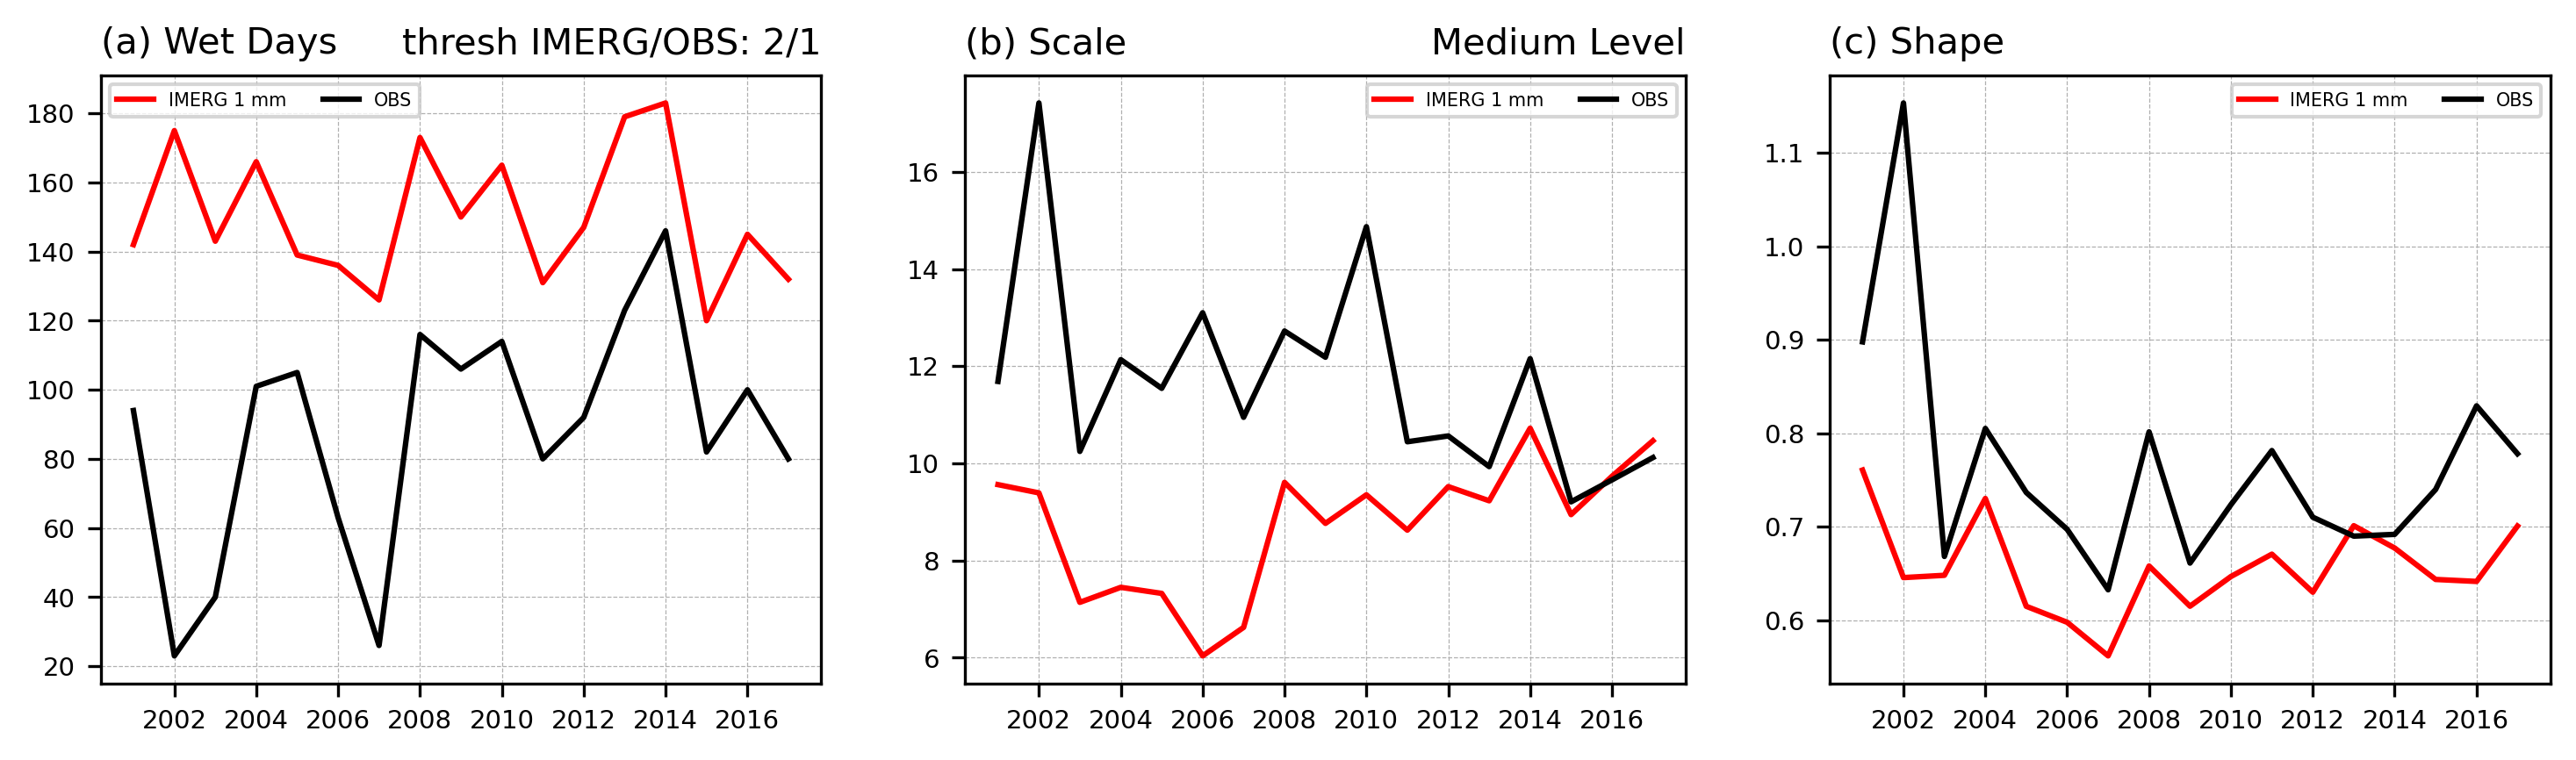

In [15]:
fig = plt.figure(figsize=(12,3),dpi=300)
gs = gridspec.GridSpec(1,3)

ax1 = plt.subplot(gs[0,0])
ax1.plot(IMERG_WEIBULL_YEAR[:,3], IMERG_WEIBULL_YEAR[:,0], c='r', label='IMERG 1 mm')
ax1.plot(OBS_WEIBULL_YEAR[:,3], OBS_WEIBULL_YEAR[:,0], c='k', label='OBS')
ax1.legend(fontsize=5, ncol=3)
ax1.set_title('(a) Wet Days', loc='left', fontsize=10)
ax1.set_title(f'thresh IMERG/OBS: {thresh}/{thresh_OBS}', loc='right', fontsize=10)
ax1.xaxis.set_tick_params(labelsize=7)
ax1.yaxis.set_tick_params(labelsize=7)
# ax1.set_ylim(20,160)
ax1.grid(linewidth=0.3, linestyle='--')

ax1 = plt.subplot(gs[0,1])
ax1.plot(IMERG_WEIBULL_YEAR[:,3], IMERG_WEIBULL_YEAR[:,1], c='r', label='IMERG 1 mm')
ax1.plot(OBS_WEIBULL_YEAR[:,3], OBS_WEIBULL_YEAR[:,1], c='k', label='OBS')
ax1.legend(fontsize=5, ncol=3)
ax1.set_title('(b) Scale', loc='left', fontsize=10)
ax1.set_title(f'{name}',loc='right',fontsize=10)
ax1.xaxis.set_tick_params(labelsize=7)
ax1.yaxis.set_tick_params(labelsize=7)
# ax1.set_ylim(5,25)
ax1.grid(linewidth=0.3, linestyle='--')

ax1 = plt.subplot(gs[0,2])
ax1.plot(IMERG_WEIBULL_YEAR[:,3], IMERG_WEIBULL_YEAR[:,2], c='r', label='IMERG 1 mm')
ax1.plot(OBS_WEIBULL_YEAR[:,3], OBS_WEIBULL_YEAR[:,2], c='k', label='OBS')
ax1.legend(fontsize=5, ncol=3)
ax1.set_title('(c) Shape', loc='left', fontsize=10)
ax1.xaxis.set_tick_params(labelsize=7)
ax1.yaxis.set_tick_params(labelsize=7)
# ax1.set_ylim(0.5,1.3)
ax1.grid(linewidth=0.3, linestyle='--')

image_dir = f'../fig/Rainfall_OBS_IMERG_weibull.png'
print(f'Export as: {image_dir}')

ax1.set_facecolor('white')
fig.patch.set_alpha(0)
# plt.savefig(image_dir,transparent = False,bbox_inches ='tight',pad_inches = 0.01)

## Verify threshold sensivity

Text(2011, 0.42, '')

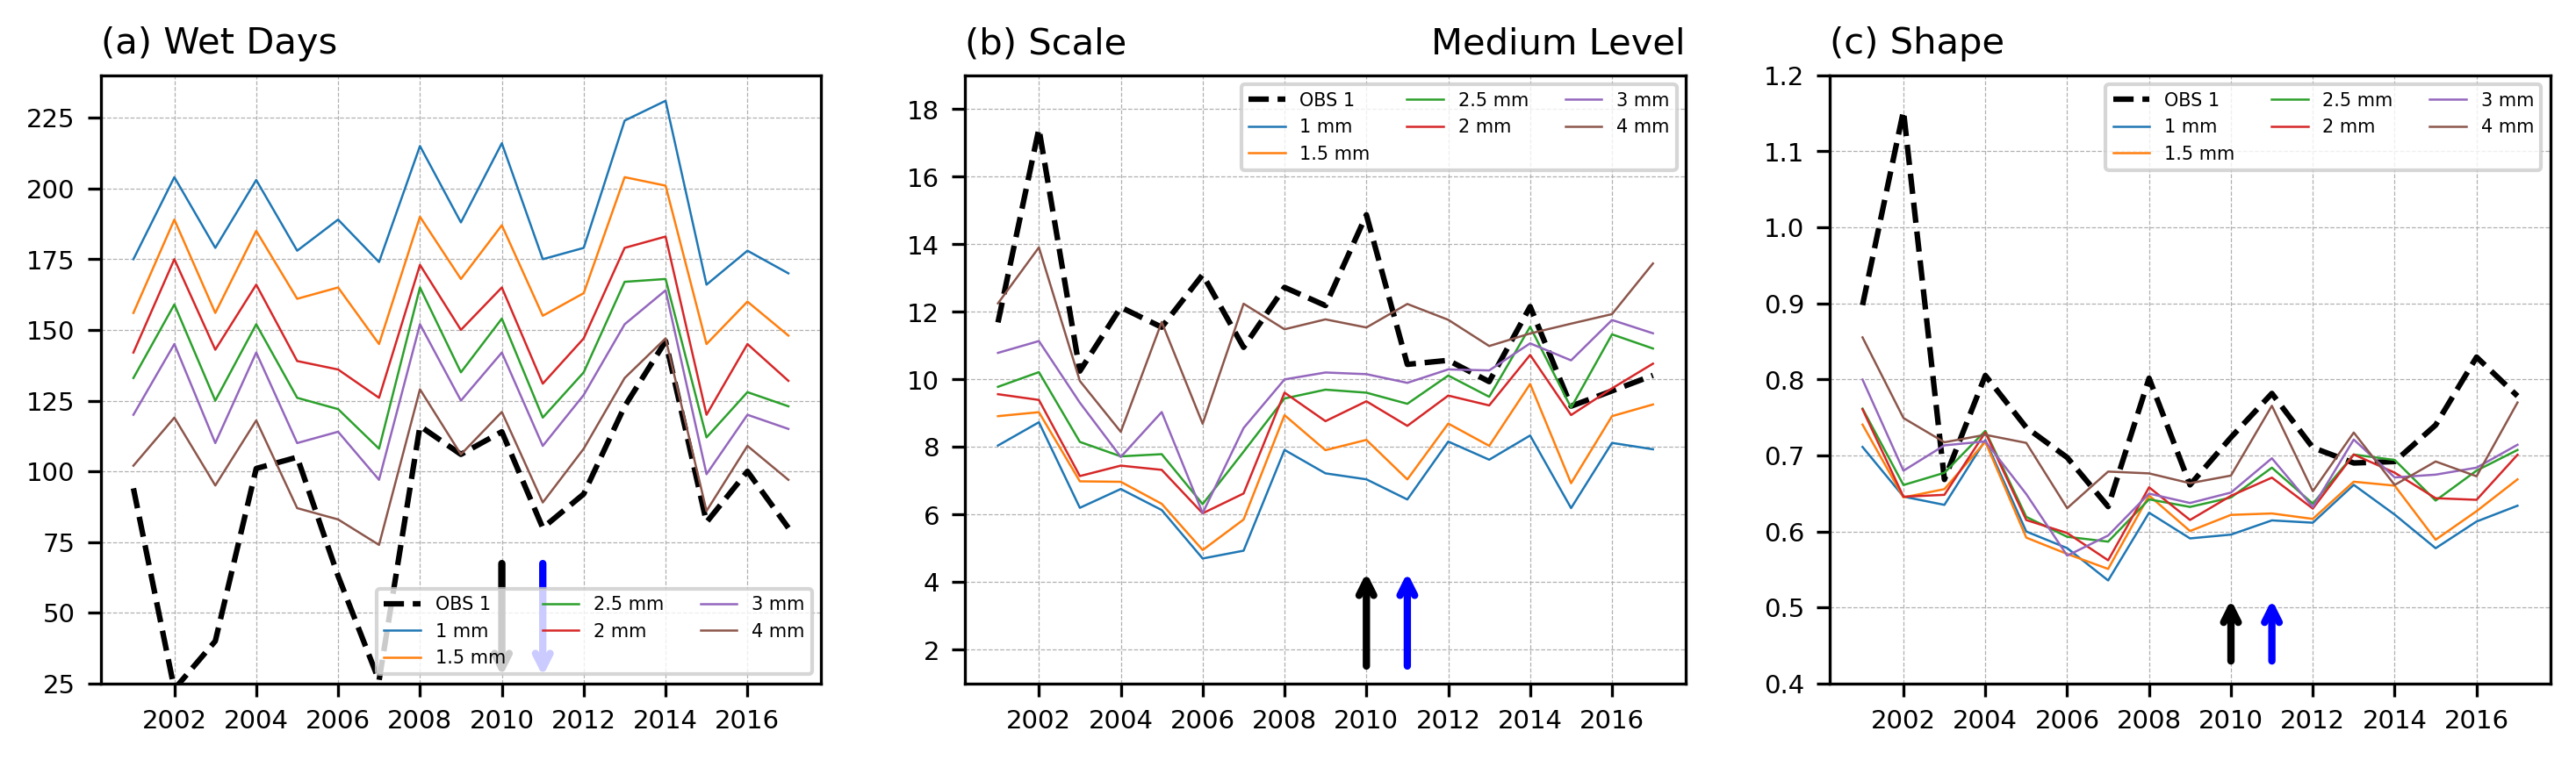

In [16]:
thresh_TEST = 1
OBS_WEIBULL_YEAR_01 = fit_yearly_weibull_update(OBS_xr, thresh=0.1, maxmiss=maxmiss)
OBS_WEIBULL_YEAR_1 = fit_yearly_weibull_update(OBS_xr, thresh=1, maxmiss=maxmiss)

thr_list = [1, 1.5, 2.5, 2, 3, 4]

fig = plt.figure(figsize=(12,3),dpi=300)
gs = gridspec.GridSpec(1,3)

ax1 = plt.subplot(gs[0,0])
ax1.plot(OBS_WEIBULL_YEAR_1[:,3], OBS_WEIBULL_YEAR_1[:,0], '--k', label='OBS 1')
ax1.set_title('(a) Wet Days', loc='left', fontsize=10)
ax1.xaxis.set_tick_params(labelsize=7)
ax1.yaxis.set_tick_params(labelsize=7)
ax1.set_ylim(25,240)
ax1.grid(linewidth=0.3, linestyle='--')

ax2 = plt.subplot(gs[0,1])
ax2.plot(OBS_WEIBULL_YEAR_1[:,3], OBS_WEIBULL_YEAR_1[:,1], '--k', label='OBS 1')
ax2.set_title('(b) Scale', loc='left', fontsize=10)
ax2.set_title(f'{name}',loc='right',fontsize=10)
ax2.xaxis.set_tick_params(labelsize=7)
ax2.yaxis.set_tick_params(labelsize=7)
ax2.set_ylim(1,19)
ax2.grid(linewidth=0.3, linestyle='--')

ax3 = plt.subplot(gs[0,2])
ax3.plot(OBS_WEIBULL_YEAR_1[:,3], OBS_WEIBULL_YEAR_1[:,2], '--k', label='OBS 1')
ax3.set_title('(c) Shape', loc='left', fontsize=10)
ax3.xaxis.set_tick_params(labelsize=7)
ax3.yaxis.set_tick_params(labelsize=7)
ax3.set_ylim(0.4,1.2)
ax3.grid(linewidth=0.3, linestyle='--')

for tt in thr_list:
    IMERG_WEIBULL_YEAR_for = fit_yearly_weibull_update(IMERG_pixel_xr, thresh=tt, maxmiss=maxmiss)
    ax1.plot(IMERG_WEIBULL_YEAR_for[:,3], IMERG_WEIBULL_YEAR_for[:,0], linewidth=0.6, label=f'{tt} mm')
    ax2.plot(IMERG_WEIBULL_YEAR_for[:,3], IMERG_WEIBULL_YEAR_for[:,1], linewidth=0.6, label=f'{tt} mm')
    ax3.plot(IMERG_WEIBULL_YEAR_for[:,3], IMERG_WEIBULL_YEAR_for[:,2], linewidth=0.6, label=f'{tt} mm')

ax1.legend(fontsize=5, ncol=3)
ax2.legend(fontsize=5, ncol=3)
ax3.legend(fontsize=5, ncol=3)

ax1.annotate('', xy=(2010, 25), xytext=(2010, 70),
            arrowprops=dict(arrowstyle='->', lw=2, color='k'))
ax1.annotate('', xy=(2011, 25), xytext=(2011, 70),
            arrowprops=dict(arrowstyle='->', lw=2, color='b'))

ax2.annotate('', xy=(2010, 4.5), xytext=(2010, 1.3),
            arrowprops=dict(arrowstyle='->', lw=2, color='k'))
ax2.annotate('', xy=(2011, 4.5), xytext=(2011, 1.3),
            arrowprops=dict(arrowstyle='->', lw=2, color='b'))

ax3.annotate('', xy=(2010, 0.52), xytext=(2010, 0.42),
            arrowprops=dict(arrowstyle='->', lw=2, color='k'))
ax3.annotate('', xy=(2011, 0.52), xytext=(2011, 0.42),
            arrowprops=dict(arrowstyle='->', lw=2, color='b'))

In [17]:
box_3h, bcond = create_box(DATA, clat, clon, npix, reso=0.2)
print(f'Dimension of box3d: {box_3h.shape}')

Dimension of box3d: (3, 3, 49672)


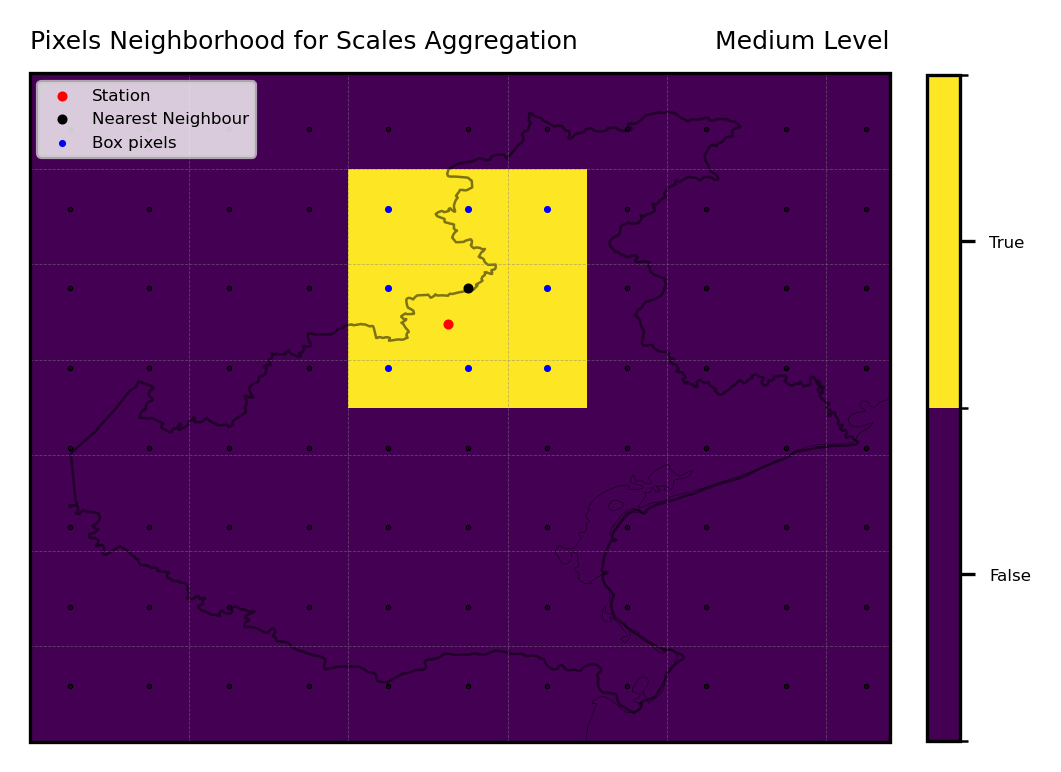

In [18]:
Station_pos = CL_INFO['Lat'], CL_INFO['Lon'] 
close_pixel = clat, clon
image_out = f'../fig/Veneto_IMERG_{name.replace(' ','_')}_{yy_s}_{yy_e}_scale.png'

plot_neighborhood(box_3h, lon2d, lat2d, bcond, Station_pos, close_pixel, name, image_out, save=False)

In [19]:
smax = box_3h.shape[0] # max spatial scale
tscales = np.array([1, 2, 3, 4, 5, 6, 8, 10, 12, 16, 20, 24, 36, 48, 96])*dt
tscales = tscales[tscales < tmax + 0.001]
xscales = np.arange(1, smax+1)
xscales_km = xscales*L1
ntscales = np.size(tscales)
nsscales = np.size(xscales)

print(f'Maximum Spatial Scale: {smax*L1} km')
print(f'Number of Spatial Scale: {nsscales}')
print()
print(f'Maximum time Scale   : {tmax} h')
print(f'Number of Time Scale: {ntscales}')

Maximum Spatial Scale: 75 km
Number of Spatial Scale: 3

Maximum time Scale   : 48 h
Number of Time Scale: 10


## Wet Fraction

In [20]:
WET_MATRIX = space_time_scales_agregations(box_3h, L1, CONDITION, tscales, xscales, npix, thresh)

Using condition: OVERLEAP

Agregation for time scale: 3 hours
Mean wet fraction for scale: 25 km
Mean wet fraction for scale: 50 km
Mean wet fraction for scale: 75 km

Agregation for time scale: 6 hours
Mean wet fraction for scale: 25 km
Mean wet fraction for scale: 50 km
Mean wet fraction for scale: 75 km

Agregation for time scale: 9 hours
Mean wet fraction for scale: 25 km
Mean wet fraction for scale: 50 km
Mean wet fraction for scale: 75 km

Agregation for time scale: 12 hours
Mean wet fraction for scale: 25 km
Mean wet fraction for scale: 50 km
Mean wet fraction for scale: 75 km

Agregation for time scale: 15 hours
Mean wet fraction for scale: 25 km
Mean wet fraction for scale: 50 km
Mean wet fraction for scale: 75 km

Agregation for time scale: 18 hours
Mean wet fraction for scale: 25 km
Mean wet fraction for scale: 50 km
Mean wet fraction for scale: 75 km

Agregation for time scale: 24 hours
Mean wet fraction for scale: 25 km
Mean wet fraction for scale: 50 km
Mean wet fraction 

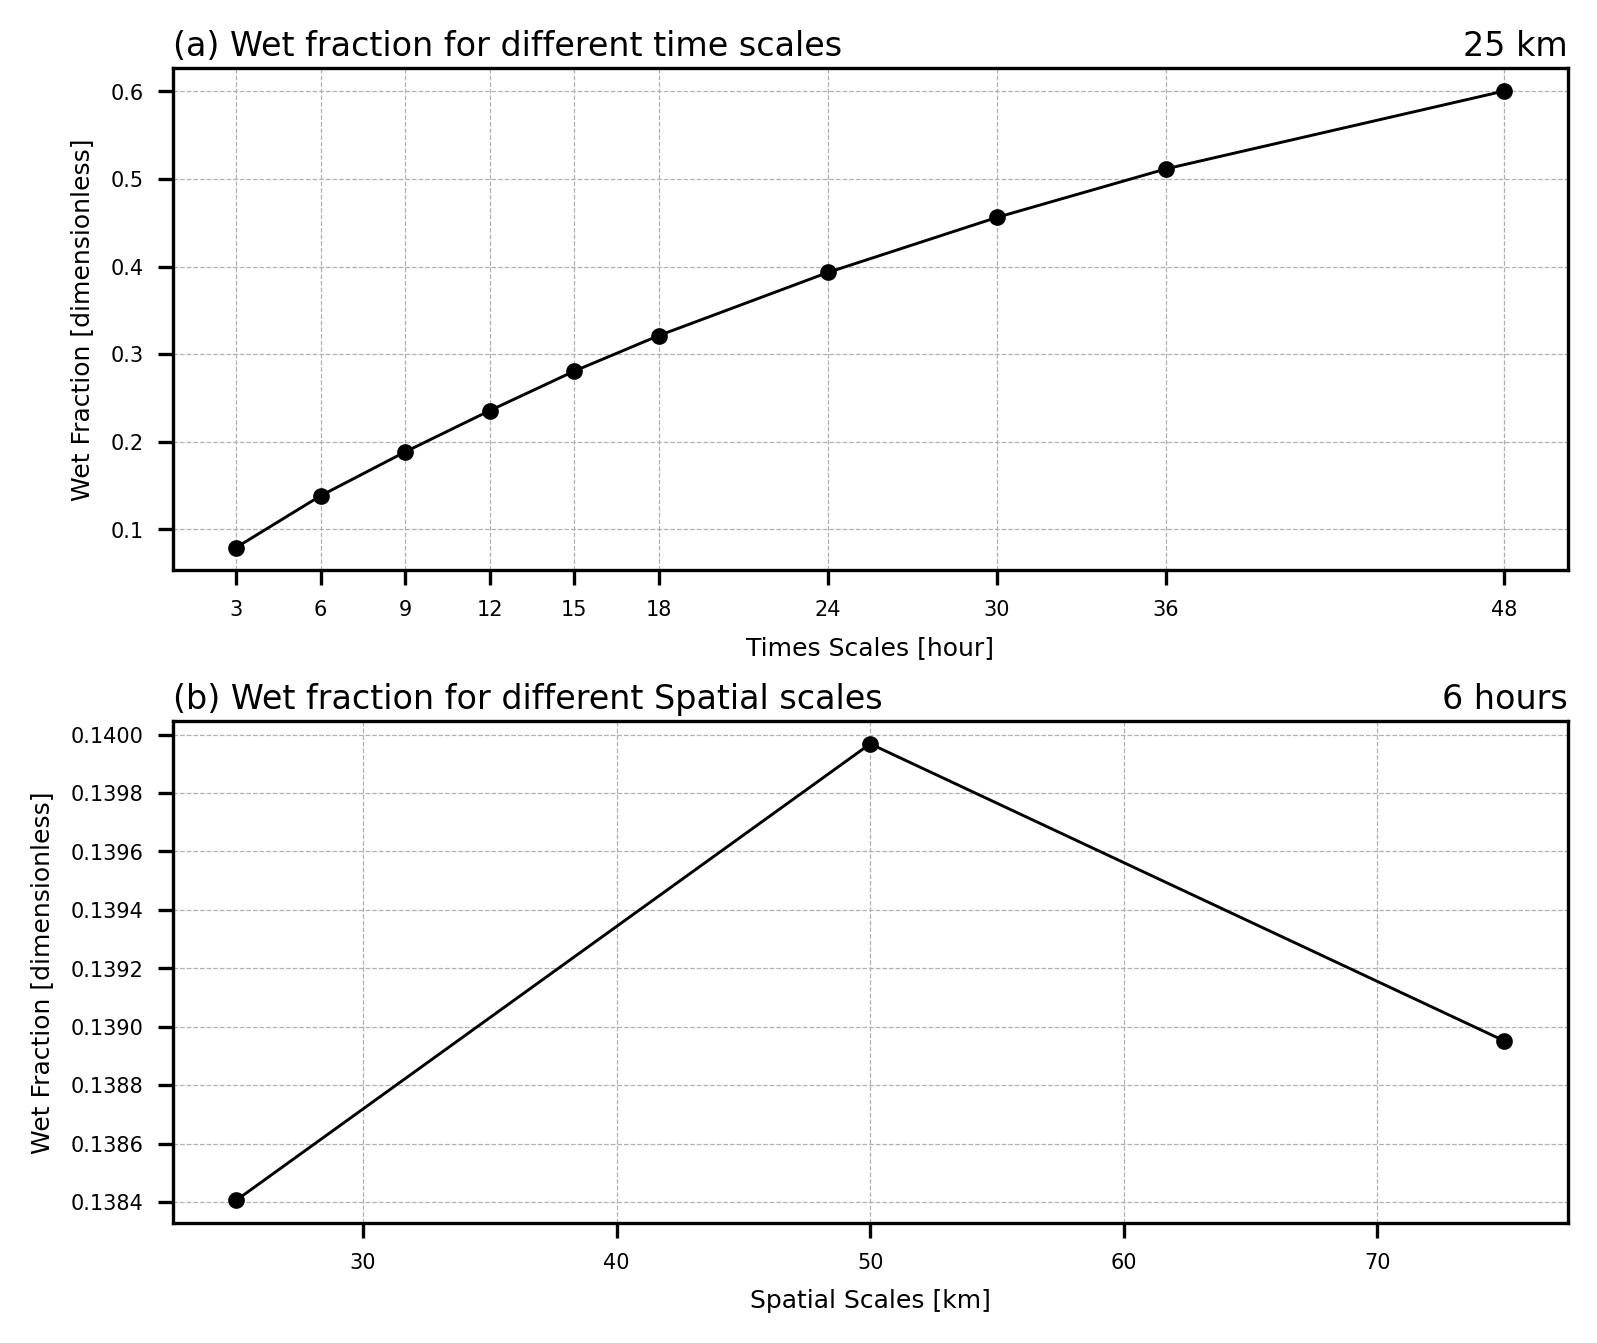

In [21]:
image_dir = f'../fig/Veneto_IMERG_{name.replace(' ','_')}_{yy_s}_{yy_e}_aggregation.png'
plot_scales_aggregation(WET_MATRIX, xscales_km, tscales, 0, 1, image_dir, save=False)

## Wet Matrix Interpolation

In [22]:
ninterp = 2000 # number of interpolation in time dimension

xscales_km_2d, tscales_2d = np.meshgrid(xscales_km, tscales)

ntscales = np.size(tscales)
nxscales = np.size(xscales)

tscales_INTER = np.linspace(np.min(tscales), np.max(tscales), ninterp) # 2000 values between min y max de time scale
WET_MATRIX_INTER = np.zeros((ninterp, nxscales)) # 2000, 5

for col in range(nxscales):
    WET_MATRIX_INTER[:, col] = np.interp(tscales_INTER, tscales, WET_MATRIX[:, col]) # Interpolated wet fraction matrix

## Wet Matrix Extrapolation

In [23]:
WET_MATRIX_EXTRA, new_spatial_scale = wet_matrix_extrapolation(WET_MATRIX_INTER, xscales_km, tscales_INTER, L1, npix)

## Compute Beta

In [24]:
origin_ref = [origin_x, origin_t]
target_ref = [target_x, target_t]
image_dir = f'../fig/Veneto_IMERG_{name.replace(' ','_')}_{yy_s}_{yy_e}_WF_{fig_val}.png'

In [25]:
beta = compute_beta(WET_MATRIX_EXTRA, origin_ref, target_ref, new_spatial_scale, tscales_INTER)
print(f'beta: {beta}')

beta: 1.2194913725051908


## Plot Wet Fraction Matrix

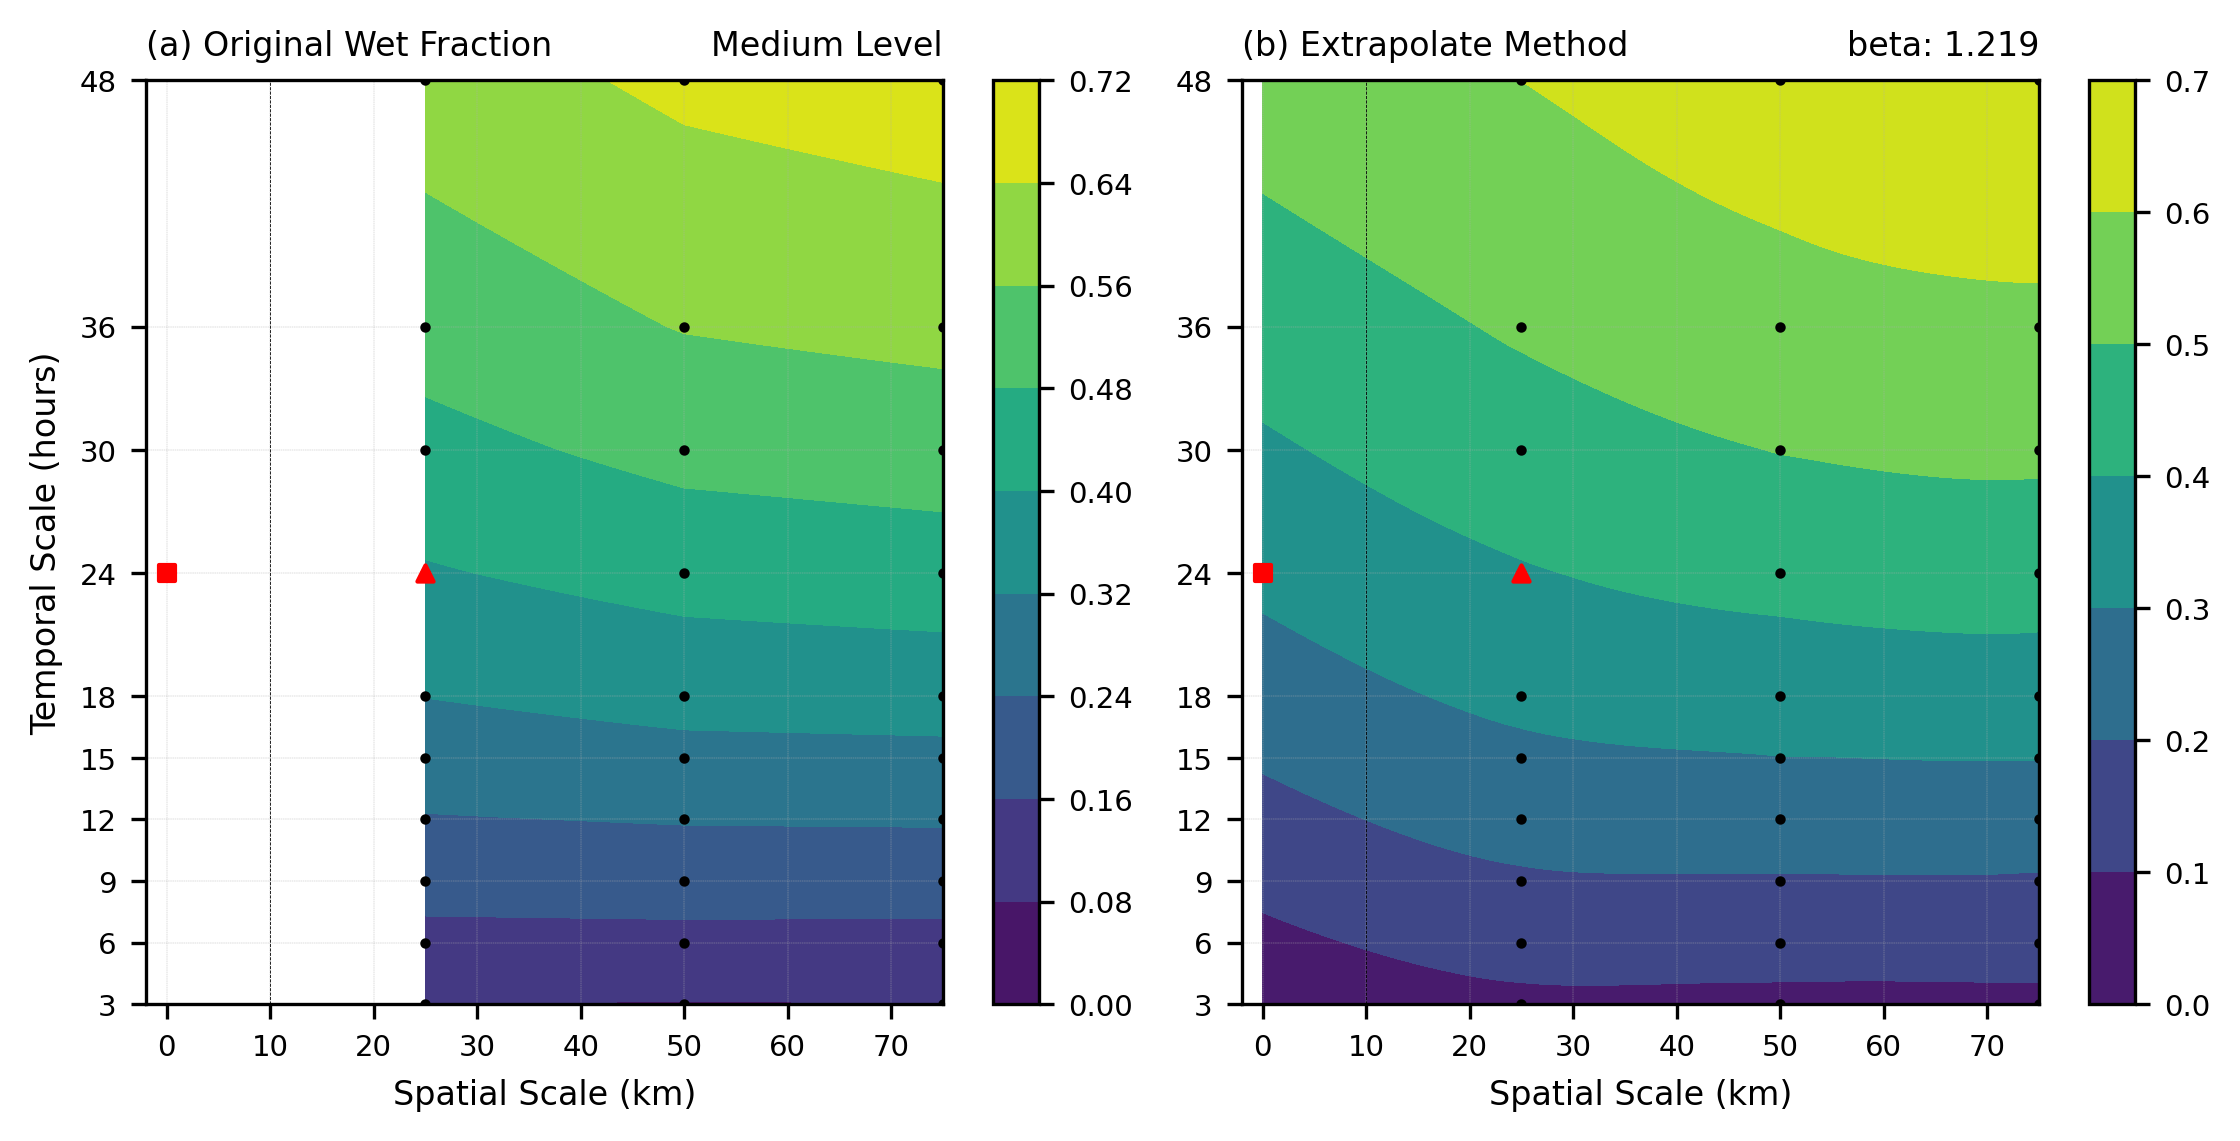

In [26]:
plot_wet_fraction_matrix(
                WET_MATRIX_INTER, 
                xscales_km, tscales, tscales_INTER, 
                WET_MATRIX_EXTRA, 
                new_spatial_scale, 
                origin_ref, target_ref, 
                name, image_dir, save=False)

## Autocorrelation Neighborhood and fit

In [27]:
print(f'thresh: {thresh}')
vdist, vcorr, distance_vector = autocorrelation_neighborhood(box_3h, t_target=target_t, thresh=thresh, cor_method = 'spearman')
FIT, _ = curve_fit(str_exp_fun, vdist, vcorr)
FIT_d0, FIT_mu0 = FIT
FIT, _ = curve_fit(epl_fun, vdist, vcorr)
FIT_eps, FIT_alp = FIT

thresh: 2


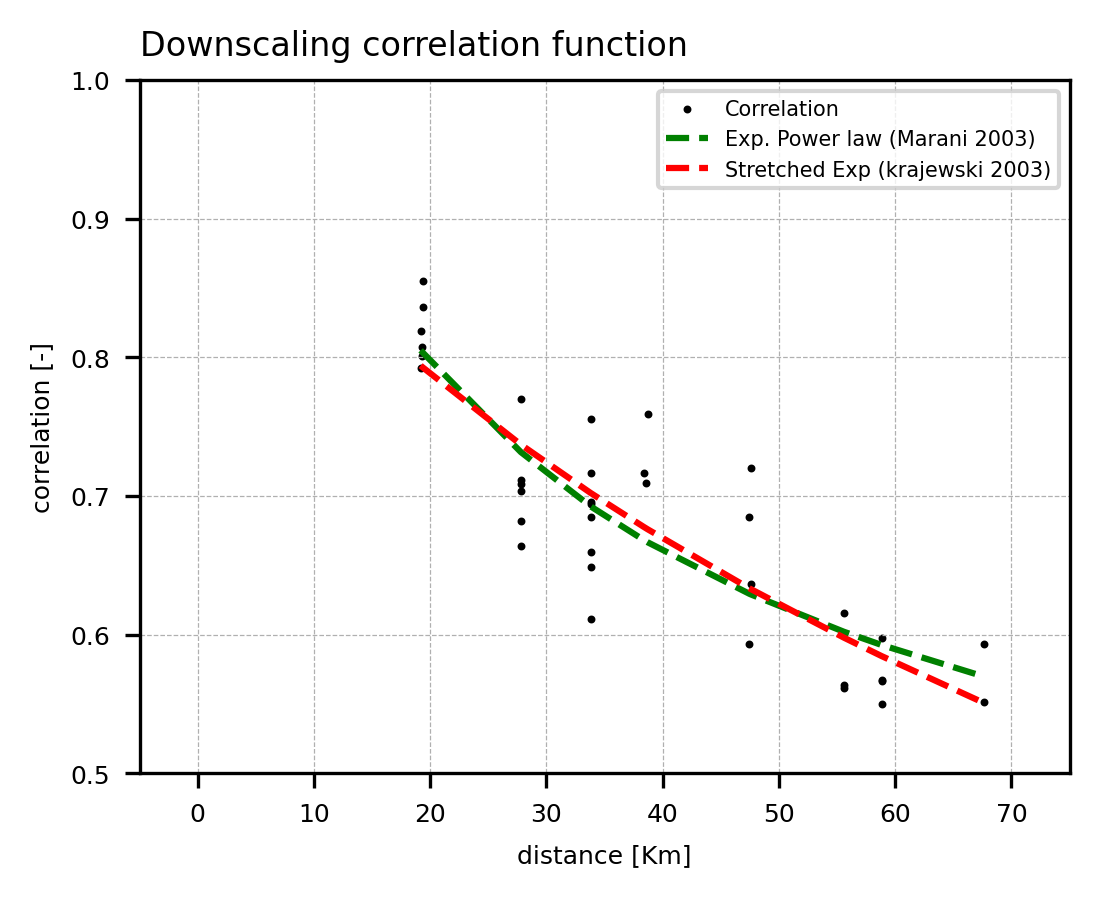

In [28]:
nameout = f'../fig/Corr_function_Marani_Krajewski.png'
plot_autocorrelation(vdist, vcorr, FIT_eps, FIT_alp, FIT_d0, FIT_mu0, nameout, save=False)

In [29]:
vdist_sorted = np.sort(vdist) # order distance
vcorr_sorted = vcorr[np.argsort(vdist)] # order correlation in relation to distance
toll_cluster = 0.5

cluster = np.zeros(len(vdist_sorted))
count = 0
for i in range(1, len(vdist_sorted)):
    if np.abs(vdist_sorted[i]-vdist_sorted[i-1]) < toll_cluster:
        cluster[i] = count
    else:
        count = count + 1
        cluster[i] = count

clust = set(cluster) # Extract only the uniques values
nclust = len(clust) # Numero de grupos
print(f'Number of clusters: {nclust}')

vdist_ave = np.zeros(nclust)
vcorr_ave = np.zeros(nclust)
for ei, elem in enumerate(clust):
    di = vdist_sorted[cluster==elem] # Distance
    ci = vcorr_sorted[cluster==elem] # Correlation
    vdist_ave[ei] = np.mean(di) # Mean Distance
    vcorr_ave[ei] = np.mean(ci) # Mean Correlation

Number of clusters: 8


In [30]:
FIT, _ = curve_fit(epl_fun, vdist_ave, vcorr_ave)
FIT_ave_eps, FIT_ave_alp = FIT

Text(0, 0.5, 'Spearman Correlation')

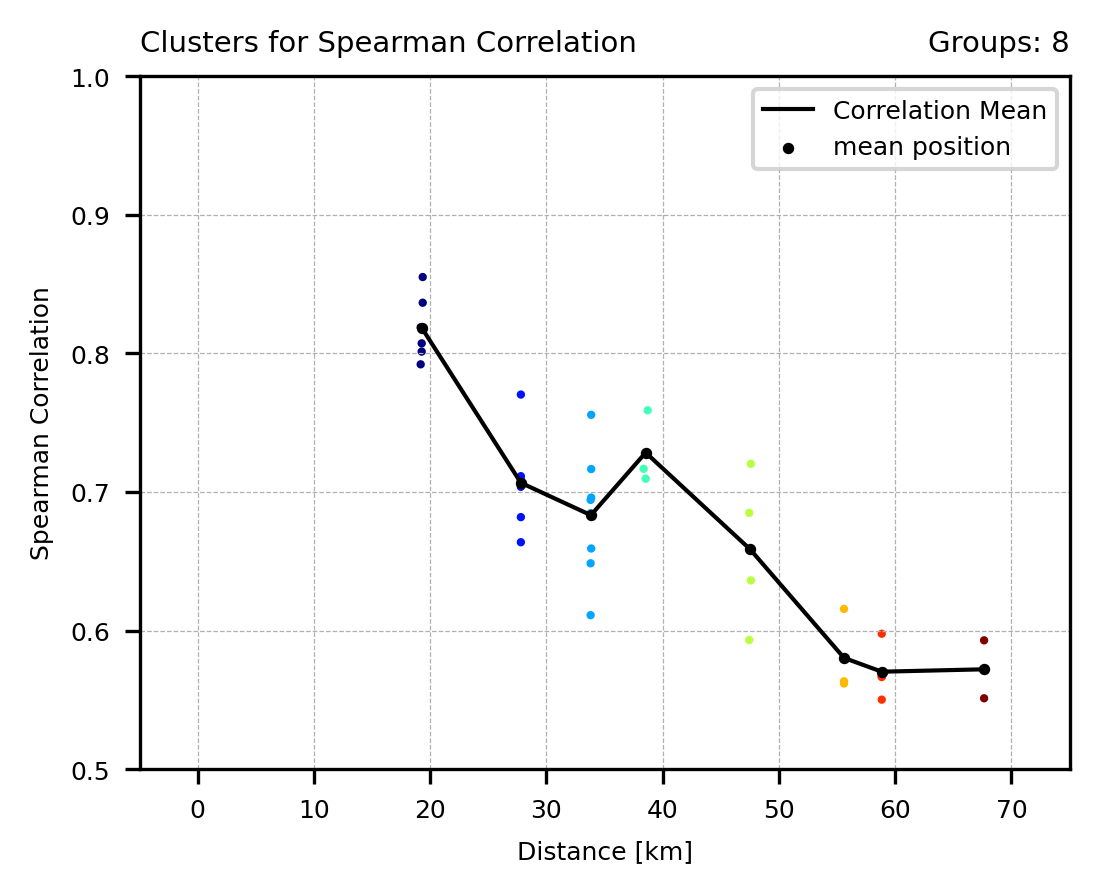

In [31]:
fig = plt.figure(figsize=(4,3),dpi=300)
gs = gridspec.GridSpec(1,1)

ax1 = plt.subplot(gs[0, 0])
ax1.scatter(vdist_sorted, vcorr_sorted, s=1, c=cluster, cmap='jet') # Sorted for cluste has same color
ax1.plot(vdist_ave, vcorr_ave, '-k', linewidth=1, label='Correlation Mean')
ax1.scatter(vdist_ave, vcorr_ave, s=3, c='k', label='mean position', zorder=5)

ax1.grid(linewidth=0.3, linestyle='--')
ax1.legend(fontsize = 6)

ax1.xaxis.set_tick_params(labelsize=6)
ax1.yaxis.set_tick_params(labelsize=6)

ax1.set_xlim([-5, min(100, 10*(np.round(np.max(vdist))//10+1.5))])
ax1.set_ylim([0.5, 1.0])

ax1.set_title('Clusters for Spearman Correlation', loc='left', fontsize=7)
ax1.set_title(f'Groups: {nclust}', loc='right', fontsize=7)
ax1.set_xlabel('Distance [km]', fontsize=6)
ax1.set_ylabel('Spearman Correlation', fontsize=6)

## Compute Alpha

In [47]:
bounds = [(0.0, 100.0),(0, 1)]
def myfun(pardown):
        return myfun_sse(vdist_ave, vcorr_ave, pardown, L1, acf=acf)

resmin = differential_evolution(myfun, bounds, disp=True, tol = 0.005, atol = 0.005, seed=42, workers=10) # 0.05

param1 = resmin.x[0]
param2 = resmin.x[1]
print()
print(f'Optimal values: {resmin.x[0]} and {resmin.x[1]}')

differential_evolution step 1: f(x)= 0.010439119781746314
differential_evolution step 2: f(x)= 0.010439119781746314
differential_evolution step 3: f(x)= 0.010439119781746314
differential_evolution step 4: f(x)= 0.00873248870582976
differential_evolution step 5: f(x)= 0.007734963427605614
differential_evolution step 6: f(x)= 0.007147341742230355
differential_evolution step 7: f(x)= 0.006831135083459476
differential_evolution step 8: f(x)= 0.006831135083459476
differential_evolution step 9: f(x)= 0.006831135083459476
differential_evolution step 10: f(x)= 0.006831135083459476
differential_evolution step 11: f(x)= 0.006831135083459476
differential_evolution step 12: f(x)= 0.006831135083459476
differential_evolution step 13: f(x)= 0.006831135083459476
Polishing solution with 'L-BFGS-B'

Optimal values: 0.05979336707967822 and 0.30749547821124995


In [48]:
stations_cor_dir = '/home/arturo/github/Padova/data/veneto_dist_corr_1mm.csv'
stations_corr = pd.read_csv(stations_cor_dir)
stations_corr = stations_corr.dropna()

FIT, _ = curve_fit(epl_fun, stations_corr['dist'].values, stations_corr['corr'].values)
OBS_eps, OBS_alp = FIT
print(OBS_eps, OBS_alp)

12.250839236537857 0.16446216677766615


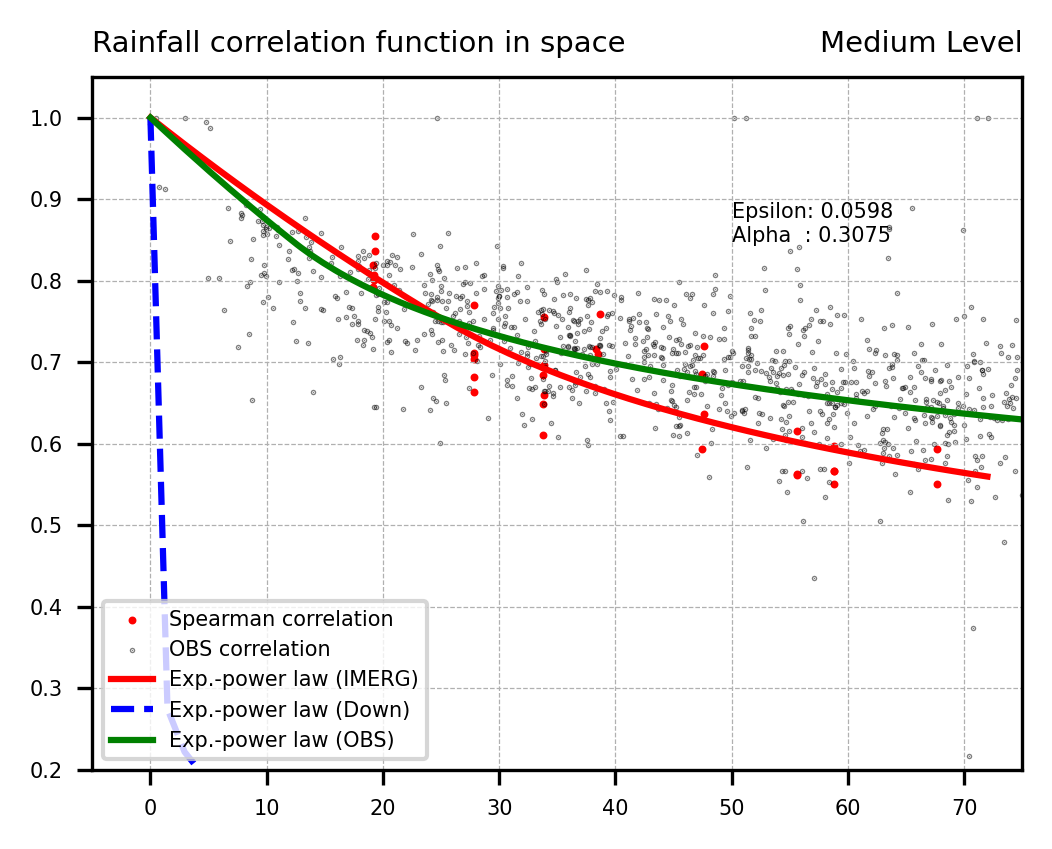

In [49]:
xx = np.linspace(0.0, min(100, 10*(np.round(np.max(vdist))//10+1.2)))

fig = plt.figure(figsize=(4,3),dpi=300)
gs = gridspec.GridSpec(1,1)

ax1 = plt.subplot(gs[0, 0])
ax1.scatter(vdist, vcorr, s=0.8, c='r', label='Spearman correlation')
# ax1.scatter(vdist_ave, vcorr_ave, s=3, c='k', label='Mean-cluster correlation')
ax1.scatter(stations_corr['dist'].values, stations_corr['corr'].values, s=0.1, c='k', alpha=0.5, label='OBS correlation')

ax1.annotate(f'Epsilon: {np.round(param1,4)}', xy=(50, 0.885), xytext=(50, 0.885),
                textcoords='data', fontsize=5, color='black',ha='left', va='center')
ax1.annotate(f'Alpha  : {np.round(param2,4)}', xy=(50, 0.855), xytext=(50, 0.855),
                textcoords='data', fontsize=5, color='black',ha='left', va='center')

if acf == 'mar':
    ax1.plot(xx, epl_fun(xx, FIT_eps, FIT_alp), '-r', label='Exp.-power law (IMERG)')
    ax1.plot(xx, epl_fun(xx, param1, param2), '--b', label='Exp.-power law (Down)')
    ax1.plot(stations_corr['dist'].values, epl_fun(stations_corr['dist'].values, OBS_eps, OBS_alp), '-g', label='Exp.-power law (OBS)')
elif acf == 'str':
    ax1.plot(xx, str_exp_fun(xx, FIT_d0, FIT_mu0), '-r', label='Exp.-power law (IMERG)')
    ax1.plot(xx, str_exp_fun(xx, param1, param2), '--b', label='Exp.-power law (Down)')
    ax1.plot(stations_corr['dist'].values, epl_fun(stations_corr['dist'].values, OBS_eps, OBS_alp), '-g', label='Exp.-power law (OBS)')

ax1.grid(linewidth=0.3, linestyle='--')
ax1.legend(fontsize = 5, loc=3)

ax1.xaxis.set_tick_params(labelsize=5)
ax1.yaxis.set_tick_params(labelsize=5)

ax1.set_xlim([-5, min(100, 10*(np.round(np.max(vdist))//10+1.5))])
ax1.set_ylim([0.2, 1.05])

ax1.set_title(f'{name}', fontsize=7, loc='right')
ax1.set_title('Rainfall correlation function in space', fontsize=7, loc='left')

# ===========================================================================
ax1.set_facecolor('white')
fig.patch.set_alpha(0)

In [35]:
print('Downscaling pdf - yearly Weibull parameters')
NYd, CYd, WYd, gamYd, _ = down_wei(IMERG_WEIBULL_YEAR[:,0], IMERG_WEIBULL_YEAR[:,1], IMERG_WEIBULL_YEAR[:,2], L1, L0, beta, (param1, param2), acf=acf)
# NYd, CYd, WYd, gamYd, _ = down_wei(IMERG_WEIBULL_YEAR[:,0], IMERG_WEIBULL_YEAR[:,1], IMERG_WEIBULL_YEAR[:,2], L1, L0, beta, (OBS_eps, OBS_alp), acf=acf)

Downscaling pdf - yearly Weibull parameters
Gamma value: 0.15064775706176306


Export as: ../fig/down_v4/Veneto_IMERG_mar_Medium_Level_2001_2017_weibull_OVERLAP_2_1mm_8.png


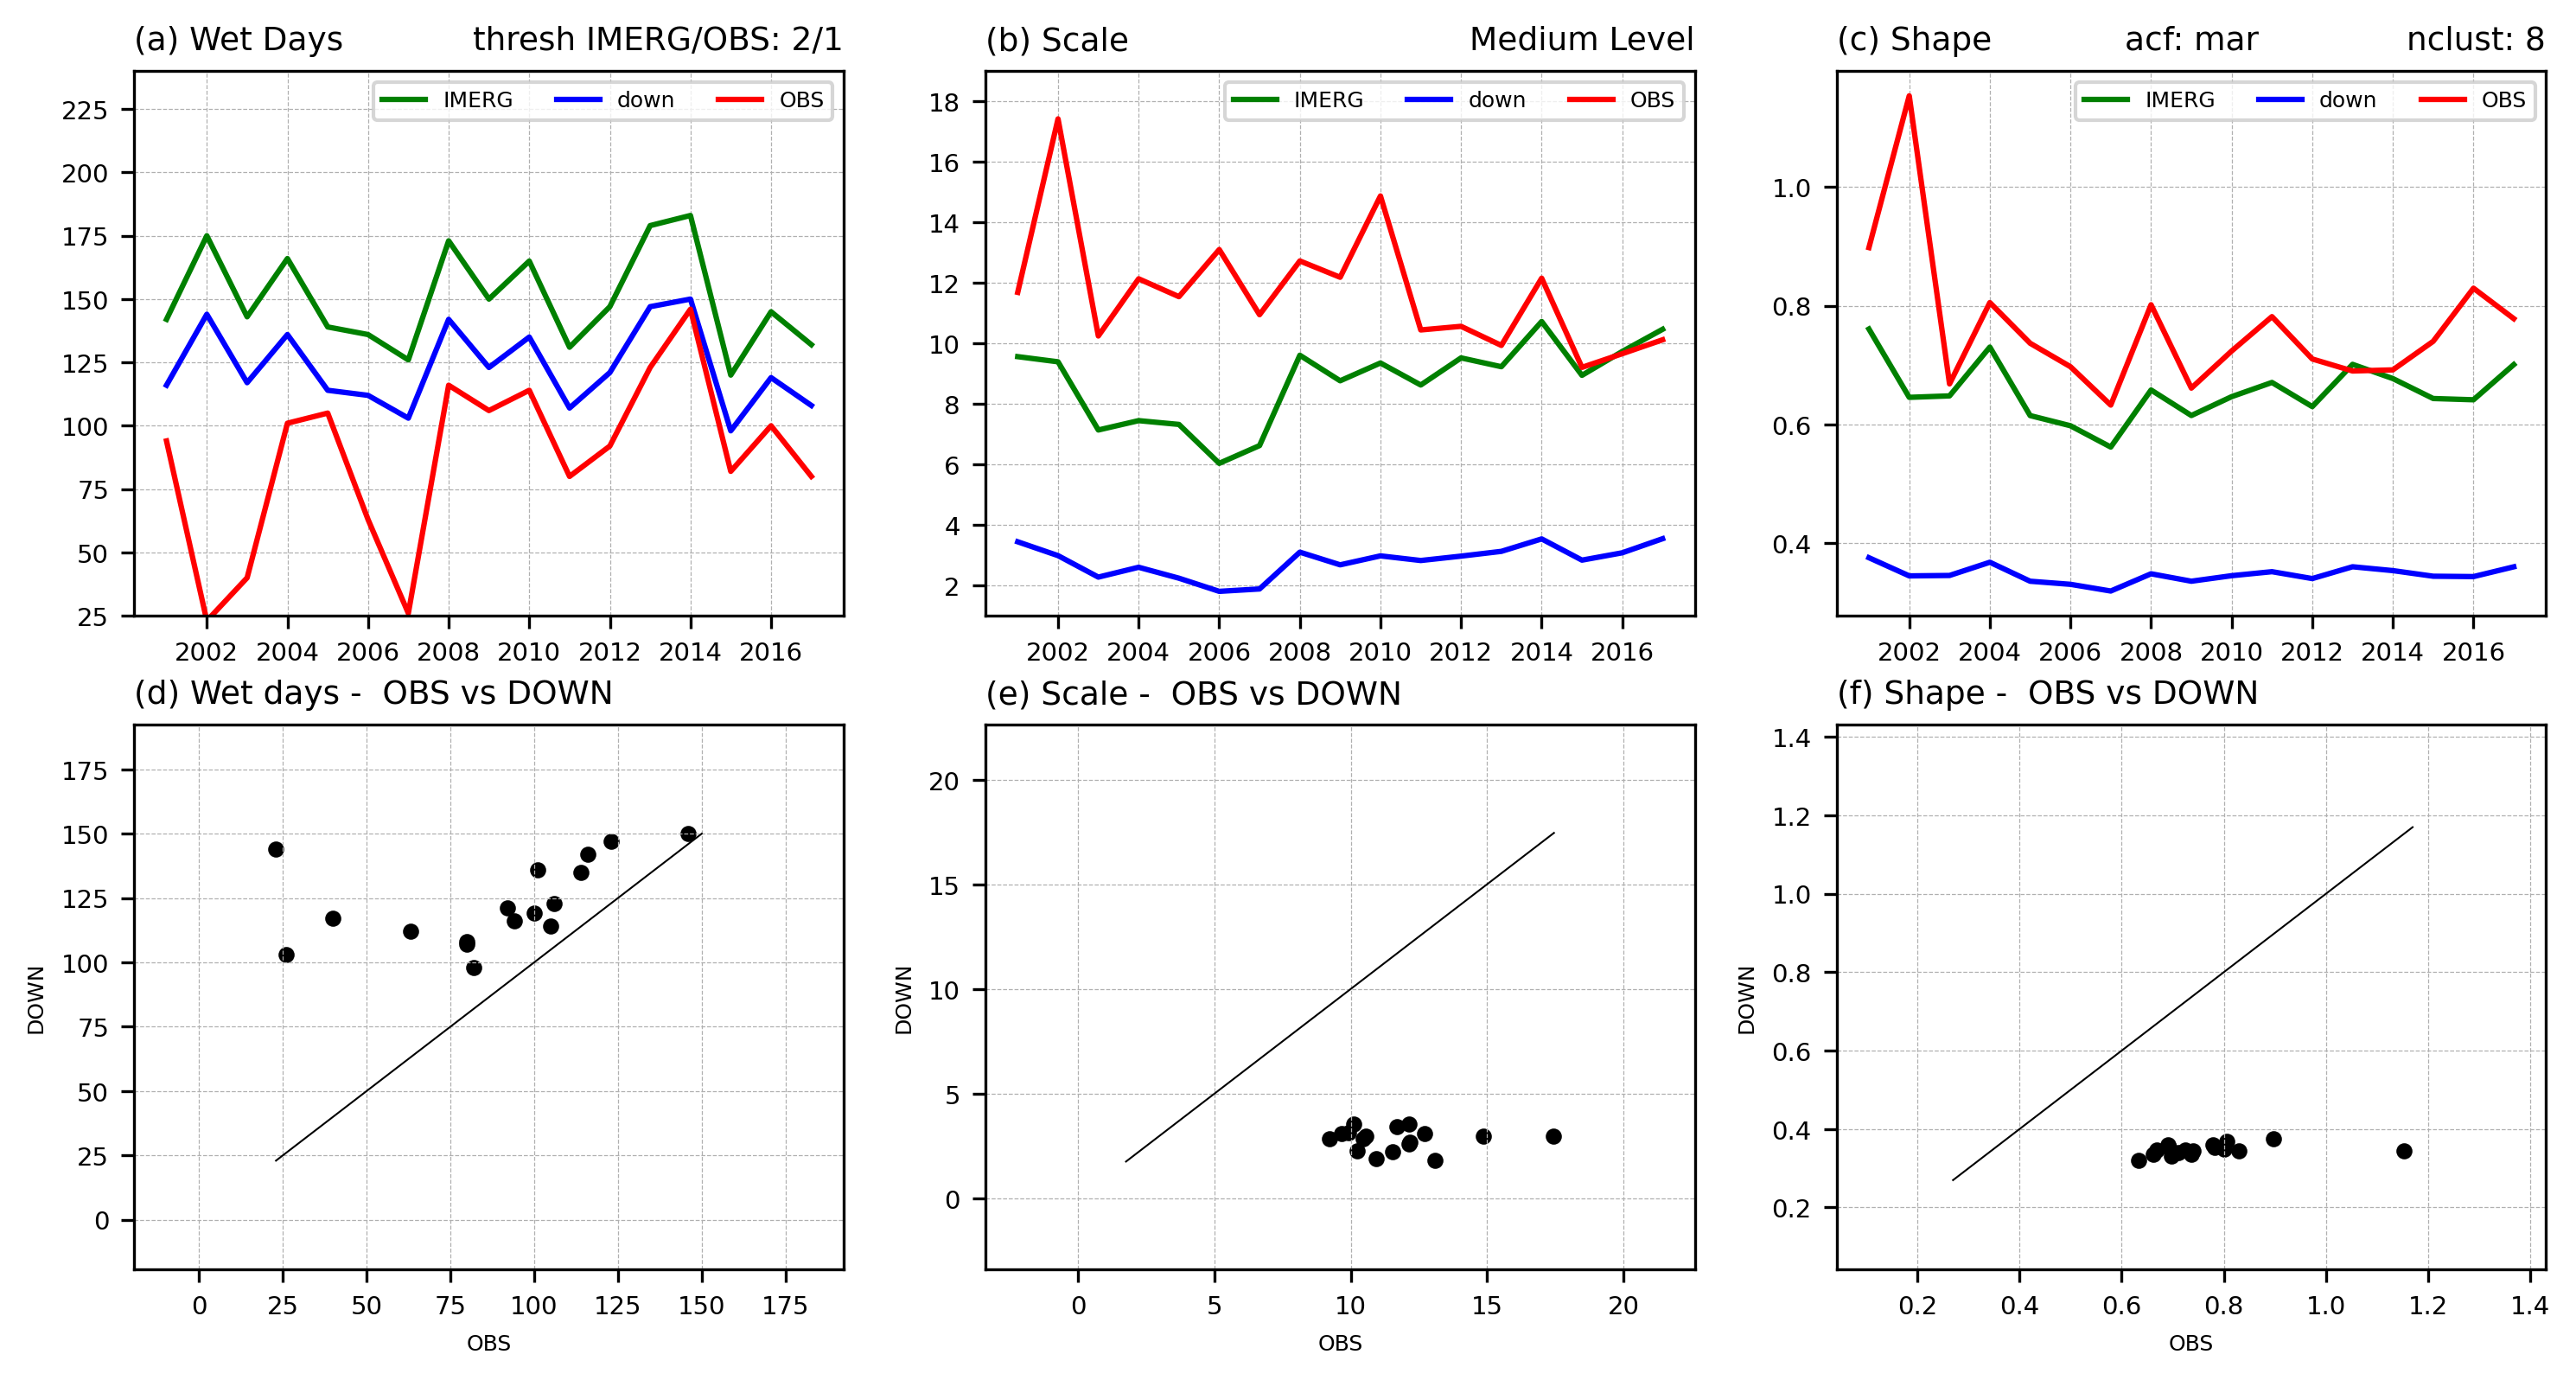

In [36]:
fig = plt.figure(figsize=(12,6),dpi=300)
gs = gridspec.GridSpec(2,3)

# ===========================================================================
ax1 = plt.subplot(gs[0,0])
ax1.plot(IMERG_WEIBULL_YEAR[:,3], IMERG_WEIBULL_YEAR[:,0], c='g', label='IMERG')
ax1.plot(IMERG_WEIBULL_YEAR[:,3], NYd, c='b', label='down')
ax1.plot(OBS_WEIBULL_YEAR[:,3], OBS_WEIBULL_YEAR[:,0], c='r', label='OBS')
ax1.legend(fontsize=6, ncol=3)
ax1.set_title('(a) Wet Days', loc='left', fontsize=9)
ax1.set_title(f'thresh IMERG/OBS: {thresh}/{thresh_OBS}', loc='right', fontsize=9)
ax1.xaxis.set_tick_params(labelsize=7)
ax1.yaxis.set_tick_params(labelsize=7)
ax1.set_ylim(25,240)
ax1.grid(linewidth=0.3, linestyle='--')

ax1 = plt.subplot(gs[0,1])
ax1.plot(IMERG_WEIBULL_YEAR[:,3], IMERG_WEIBULL_YEAR[:,1], c='g', label='IMERG')
ax1.plot(IMERG_WEIBULL_YEAR[:,3], CYd, c='b', label='down')
ax1.plot(OBS_WEIBULL_YEAR[:,3], OBS_WEIBULL_YEAR[:,1], c='r', label='OBS')
ax1.legend(fontsize=6, ncol=3)
ax1.set_title('(b) Scale', loc='left', fontsize=9)
ax1.set_title(f'{name}',loc='right',fontsize=9)
ax1.xaxis.set_tick_params(labelsize=7)
ax1.yaxis.set_tick_params(labelsize=7)
ax1.set_ylim(1,19)
ax1.grid(linewidth=0.3, linestyle='--')

ax1 = plt.subplot(gs[0,2])
ax1.plot(IMERG_WEIBULL_YEAR[:,3], IMERG_WEIBULL_YEAR[:,2], c='g', label='IMERG')
ax1.plot(IMERG_WEIBULL_YEAR[:,3], WYd, c='b', label='down')
ax1.plot(OBS_WEIBULL_YEAR[:,3], OBS_WEIBULL_YEAR[:,2], c='r', label='OBS')
ax1.legend(fontsize=6, ncol=3)
ax1.set_title('(c) Shape', loc='left', fontsize=9)
ax1.set_title(f'acf: {acf}',loc='center',fontsize=9)
ax1.set_title(f'nclust: {nclust}',loc='right',fontsize=9)
ax1.xaxis.set_tick_params(labelsize=7)
ax1.yaxis.set_tick_params(labelsize=7)
# ax1.set_ylim(0.4,1.2)
ax1.grid(linewidth=0.3, linestyle='--')

# ===========================================================================
ax1 = plt.subplot(gs[1,0])
x_limits = [np.min([np.min(OBS_WEIBULL_YEAR[:,0]),np.min(NYd)]),
        np.max([np.max(OBS_WEIBULL_YEAR[:,0]),np.max(NYd)])]
y_limits = [np.min([np.min(OBS_WEIBULL_YEAR[:,0]),np.min(NYd)]),
        np.max([np.max(OBS_WEIBULL_YEAR[:,0]),np.max(NYd)])]
ax1.scatter(OBS_WEIBULL_YEAR[:,0], NYd, s=12, c='k', label='scatter')
ax1.plot(np.arange(x_limits[0]-0.05, x_limits[1]+0.05, 0.05),
        np.arange(x_limits[0]-0.05, x_limits[1]+0.05, 0.05), linewidth=0.5, c='k')
ax1.set_xlim(x_limits[0]-(x_limits[1]-x_limits[0])/3,x_limits[1]+(x_limits[1]-x_limits[0])/3)
ax1.set_ylim(x_limits[0]-(x_limits[1]-x_limits[0])/3,x_limits[1]+(x_limits[1]-x_limits[0])/3)
ax1.xaxis.set_tick_params(labelsize=7)
ax1.yaxis.set_tick_params(labelsize=7)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_xlabel('OBS', fontsize=6)
ax1.set_ylabel('DOWN', fontsize=6)
ax1.set_title('(d) Wet days -  OBS vs DOWN', loc='left', fontsize=9)

ax1 = plt.subplot(gs[1,1])
x_limits = [np.min([np.min(OBS_WEIBULL_YEAR[:,1]),np.min(CYd)]),
        np.max([np.max(OBS_WEIBULL_YEAR[:,1]),np.max(CYd)])]
y_limits = [np.min([np.min(OBS_WEIBULL_YEAR[:,1]),np.min(CYd)]),
        np.max([np.max(OBS_WEIBULL_YEAR[:,1]),np.max(CYd)])]
ax1.scatter(OBS_WEIBULL_YEAR[:,1], CYd, s=12, c='k', label='scatter')
ax1.plot(np.arange(x_limits[0]-0.05, x_limits[1]+0.05, 0.05),
        np.arange(x_limits[0]-0.05, x_limits[1]+0.05, 0.05), linewidth=0.5, c='k')
ax1.set_xlim(x_limits[0]-(x_limits[1]-x_limits[0])/3,x_limits[1]+(x_limits[1]-x_limits[0])/3)
ax1.set_ylim(x_limits[0]-(x_limits[1]-x_limits[0])/3,x_limits[1]+(x_limits[1]-x_limits[0])/3)
ax1.xaxis.set_tick_params(labelsize=7)
ax1.yaxis.set_tick_params(labelsize=7)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_xlabel('OBS', fontsize=6)
ax1.set_ylabel('DOWN', fontsize=6)
ax1.set_title('(e) Scale -  OBS vs DOWN', loc='left', fontsize=9)

ax1 = plt.subplot(gs[1,2])
x_limits = [np.min([np.min(OBS_WEIBULL_YEAR[:,2]),np.min(WYd)]),
        np.max([np.max(OBS_WEIBULL_YEAR[:,2]),np.max(WYd)])]
y_limits = [np.min([np.min(OBS_WEIBULL_YEAR[:,2]),np.min(WYd)]),
        np.max([np.max(OBS_WEIBULL_YEAR[:,2]),np.max(WYd)])]
ax1.scatter(OBS_WEIBULL_YEAR[:,2], WYd, s=12, c='k', label='scatter')
ax1.plot(np.arange(x_limits[0]-0.05, x_limits[1]+0.05, 0.05),
        np.arange(x_limits[0]-0.05, x_limits[1]+0.05, 0.05), linewidth=0.5, c='k')
ax1.set_xlim(x_limits[0]-(x_limits[1]-x_limits[0])/3,x_limits[1]+(x_limits[1]-x_limits[0])/3)
ax1.set_ylim(x_limits[0]-(x_limits[1]-x_limits[0])/3,x_limits[1]+(x_limits[1]-x_limits[0])/3)
ax1.xaxis.set_tick_params(labelsize=7)
ax1.yaxis.set_tick_params(labelsize=7)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_xlabel('OBS', fontsize=6)
ax1.set_ylabel('DOWN', fontsize=6)
ax1.set_title('(f) Shape -  OBS vs DOWN', loc='left', fontsize=9)

# ===========================================================================
ax1.set_facecolor('white')
fig.patch.set_alpha(0)

image_dir = f'../fig/down_v4/Veneto_IMERG_{acf}_{name.replace(' ','_')}_{yy_s}_{yy_e}_weibull_{fig_val}_{thresh}_{thresh_OBS}mm_{nclust}.png'
print(f'Export as: {image_dir}')
# plt.savefig(image_dir,transparent = False,bbox_inches ='tight',pad_inches = 0.01, facecolor=None)

## Daily Scatter Plot between OBS and IMERG

Export as: ../fig/down_v4/Veneto_IMERG_scatter_Medium_Level.png


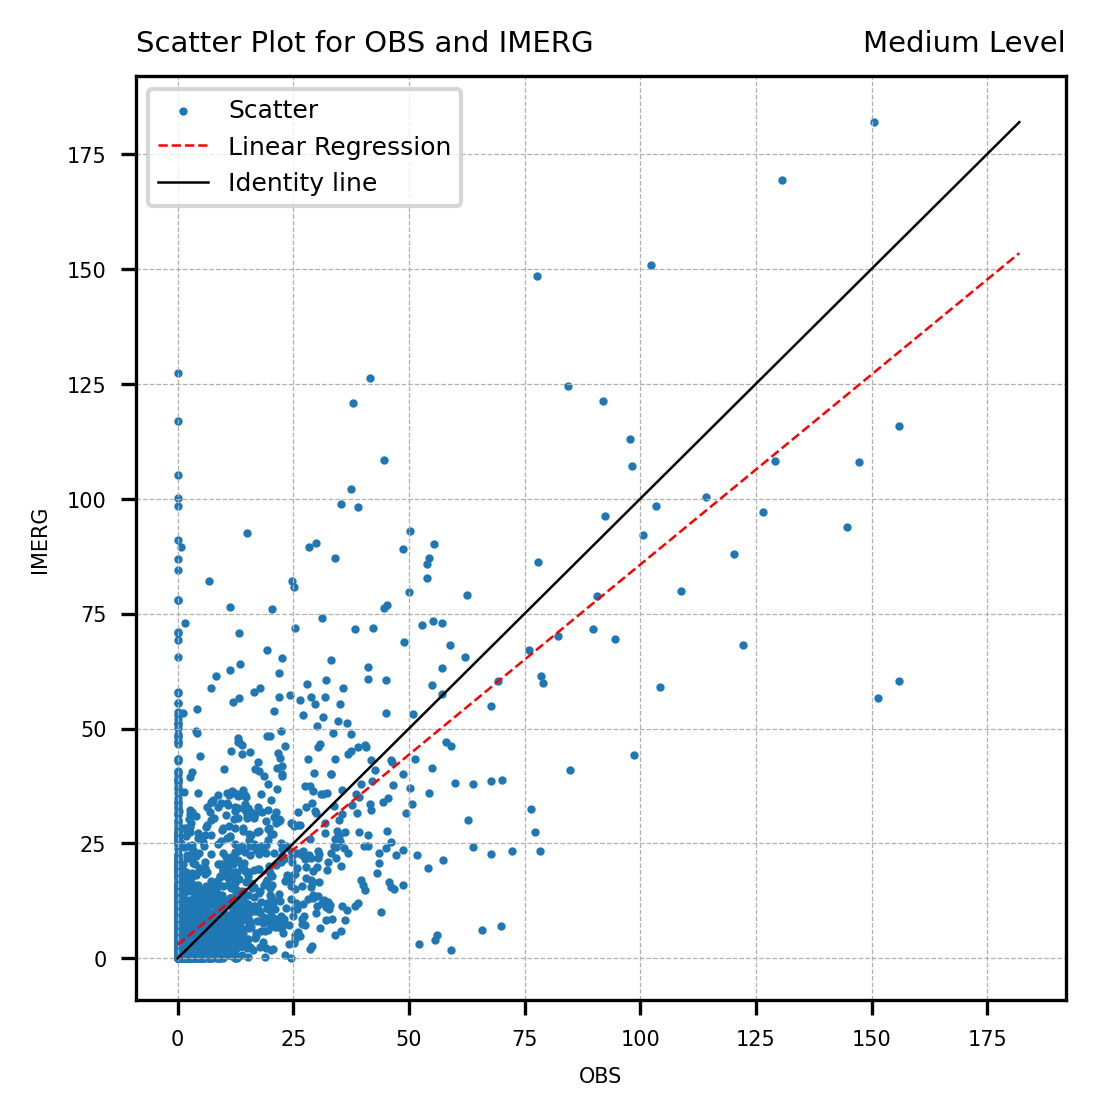

In [37]:
image_dir = f'../fig/down_v4/Veneto_IMERG_scatter_{name.replace(' ','_')}.png'
plot_scatter(OBS_xr.data, IMERG_pixel_xr.data, name, image_dir, True)

In [38]:
from scipy.special import gamma
def down_wei_beta_alpha(Ns, Cs, Ws, beta, gam):
    Ns = np.asarray(Ns)  # check if scalar input - should be the same for N,C,W
    Cs = np.asarray(Cs)
    Ws = np.asarray(Ws)
    # the three parameter mush have same shape - I only check one here
    is_scalar = False if Cs.ndim > 0 else True
    Ns.shape = (1,) * (1 - Ns.ndim) + Ns.shape
    Cs.shape = (1,) * (1 - Cs.ndim) + Cs.shape
    Ws.shape = (1,) * (1 - Ws.ndim) + Ws.shape
    m = Cs.shape[0]  # length of parameter arrays = number of blocks=

    # prob wet:: correct satellite N adding the average difference
    pws = np.mean(Ns) / 365.25
    Wd = np.zeros(m)
    Cd = np.zeros(m)
    Nd = np.zeros(m)
    for ii in range(m):
        cs = Cs[ii]
        ws = Ws[ii]
        rhs = (1/(gam*beta)) * (((2*ws*gamma(2 / ws))/((gamma(1/ws))**2)) + (gam-1)*pws)
        wpfun = lambda w: (2*w*gamma(2 / w)/(gamma(1/w))**2) - rhs

        res = fsolve(wpfun, 0.1, full_output=True,xtol=1e-06, maxfev=10000)
        
        Wd[ii] = res[0]
        info = res[1]
        fval = info['fvec']
        if fval > 1e-5:
            print('warning - downscaling function:: '
                    'there is something wrong solving fsolve!')
        Cd[ii] = (beta * Wd[ii]) * (cs / ws) * (gamma(1 / ws) / gamma(1 / Wd[ii]))
        Nd[ii] = int( np.rint( Ns[ii] / beta))

    # If Nd, Cd, Wd are a collection (example, list or array) and not a scalar, 
    # return all collection.
    Nd = Nd if not is_scalar else Nd[0]
    Cd = Cd if not is_scalar else Cd[0]
    Wd = Wd if not is_scalar else Wd[0]

    return Nd, Cd, Wd

## Sensivity Analysis

In [39]:
print(f'Beta : {beta}')
print(f'Gamma: {gamYd}')

Beta : 1.2194913725051908
Gamma: 0.15064775706176306


### Beta variable and gamma constant

In [40]:
beta_var = np.round(np.arange(0.9, 1.7, 0.1),1)
Nd_var = []
Cd_var = []
Wd_var = []
for bb in beta_var:
    Nd_tmp, Cd_tmp, Wd_tmp = down_wei_beta_alpha(IMERG_WEIBULL_YEAR[:,0], IMERG_WEIBULL_YEAR[:,1], IMERG_WEIBULL_YEAR[:,2], bb, gamYd)
    Nd_var.append(Nd_tmp)
    Cd_var.append(Cd_tmp)
    Wd_var.append(Wd_tmp)
Nd_ref, Cd_ref, Wd_ref = down_wei_beta_alpha(IMERG_WEIBULL_YEAR[:,0], IMERG_WEIBULL_YEAR[:,1], IMERG_WEIBULL_YEAR[:,2], beta, gamYd)

In [41]:
beta_shape = []
for nn in range(len(beta_var)-1):
    beta_shape.append((np.sum(Wd_var[nn+1]-Wd_var[nn]))**2)

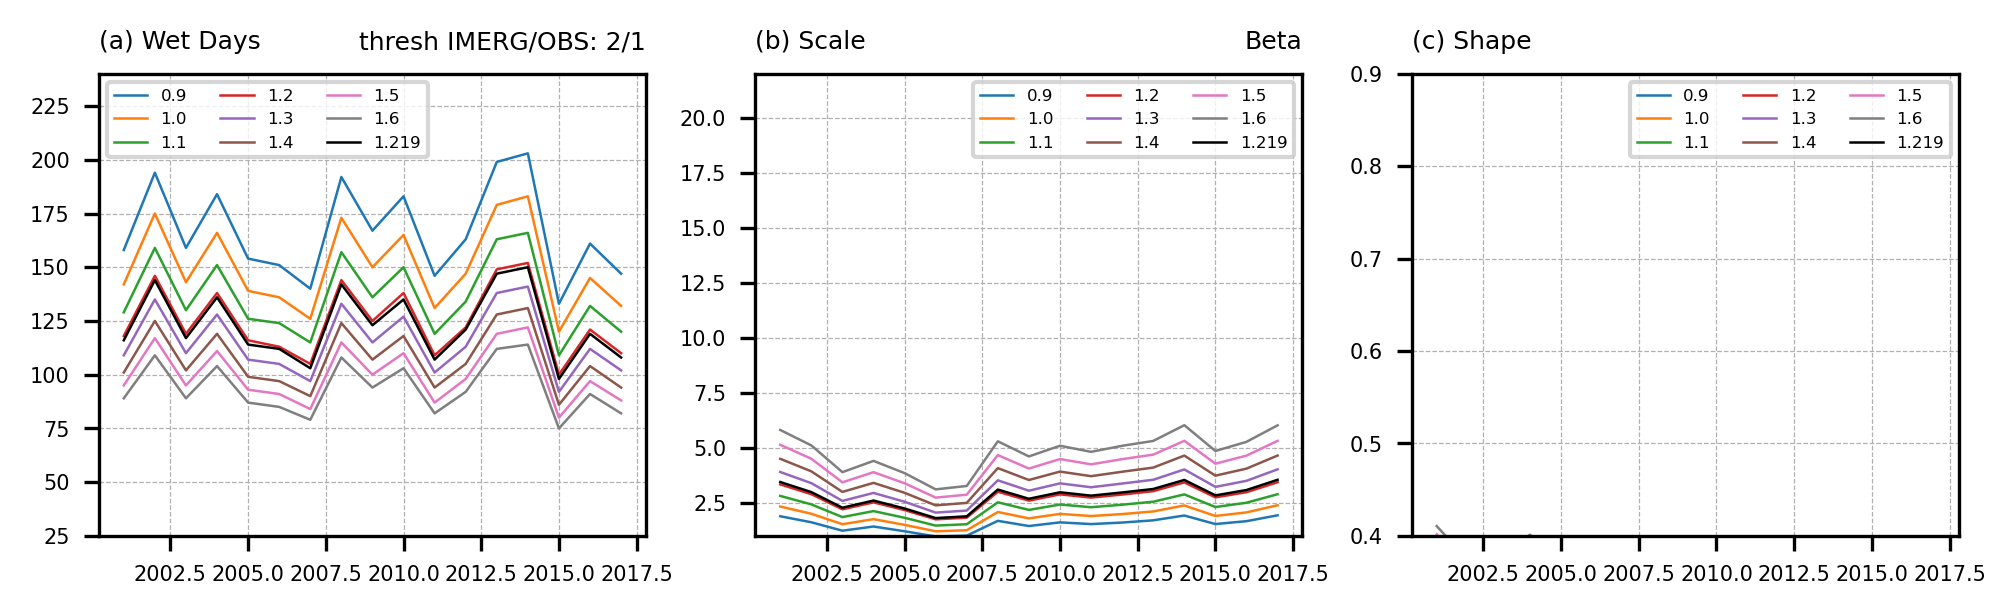

In [42]:
fig = plt.figure(figsize=(8,2),dpi=300)
gs = gridspec.GridSpec(1,3)

# ===========================================================================
ax1 = plt.subplot(gs[0,0])
for nn in range(len(beta_var)):
    ax1.plot(IMERG_WEIBULL_YEAR[:,3], Nd_var[nn], linewidth=0.6, label=beta_var[nn])
ax1.plot(IMERG_WEIBULL_YEAR[:,3], Nd_ref, c='k', linewidth=0.6, label=np.round(beta,3))

ax1.annotate('', xy=(2020, 75), xytext=(2020, 225),
            arrowprops=dict(arrowstyle='->', lw=2, color='red'))

ax1.legend(fontsize=4, ncol=3)
ax1.xaxis.set_tick_params(labelsize=5)
ax1.yaxis.set_tick_params(labelsize=5)
ax1.set_ylim(25,240)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_title('(a) Wet Days', loc='left', fontsize=6)
ax1.set_title(f'thresh IMERG/OBS: {thresh}/{thresh_OBS}', loc='right', fontsize=6)

# ===========================================================================
ax1 = plt.subplot(gs[0,1])
for nn in range(len(beta_var)):
    ax1.plot(IMERG_WEIBULL_YEAR[:,3], Cd_var[nn], linewidth=0.6, label=beta_var[nn])
ax1.plot(IMERG_WEIBULL_YEAR[:,3], Cd_ref, c='k', linewidth=0.6, label=np.round(beta,3))

ax1.annotate('', xy=(2020, 20), xytext=(2020, 5),
            arrowprops=dict(arrowstyle='->', lw=2, color='red'))

ax1.legend(fontsize=4, ncol=3)
ax1.xaxis.set_tick_params(labelsize=5)
ax1.yaxis.set_tick_params(labelsize=5)
ax1.set_ylim(1,22)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_title('(b) Scale', loc='left', fontsize=6)
ax1.set_title('Beta',loc='right',fontsize=6)

# ===========================================================================
ax1 = plt.subplot(gs[0,2])
for nn in range(len(beta_var)):
    ax1.plot(IMERG_WEIBULL_YEAR[:,3], Wd_var[nn], linewidth=0.6, label=beta_var[nn])
ax1.plot(IMERG_WEIBULL_YEAR[:,3], Wd_ref, c='k', linewidth=0.6, label=np.round(beta,3))

ax1.annotate('', xy=(2020, 0.85), xytext=(2020, 0.50),
            arrowprops=dict(arrowstyle='->', lw=2, color='red'))

ax1.legend(fontsize=4, ncol=3)
ax1.xaxis.set_tick_params(labelsize=5)
ax1.yaxis.set_tick_params(labelsize=5)
ax1.set_ylim(0.4,0.9)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_title('(c) Shape', loc='left', fontsize=6)

# ===========================================================================
ax1.set_facecolor('white')
fig.patch.set_alpha(0)

In [43]:
gamma_var = np.round(np.arange(0.6, 1, 0.05),3) # Estas variaciones no necesariamente estan correctas
Nd_var = []
Cd_var = []
Wd_var = []
for gg in gamma_var:
    Nd_tmp, Cd_tmp, Wd_tmp = down_wei_beta_alpha(IMERG_WEIBULL_YEAR[:,0], IMERG_WEIBULL_YEAR[:,1], IMERG_WEIBULL_YEAR[:,2], beta, gg)
    Nd_var.append(Nd_tmp)
    Cd_var.append(Cd_tmp)
    Wd_var.append(Wd_tmp)

Nd_ref, Cd_ref, Wd_ref = down_wei_beta_alpha(IMERG_WEIBULL_YEAR[:,0], IMERG_WEIBULL_YEAR[:,1], IMERG_WEIBULL_YEAR[:,2], beta, gamYd)

In [44]:
gamma_shape = []
for nn in range(len(gamma_var)-1):
    gamma_shape.append((np.sum(Wd_var[nn+1]-Wd_var[nn]))**2)

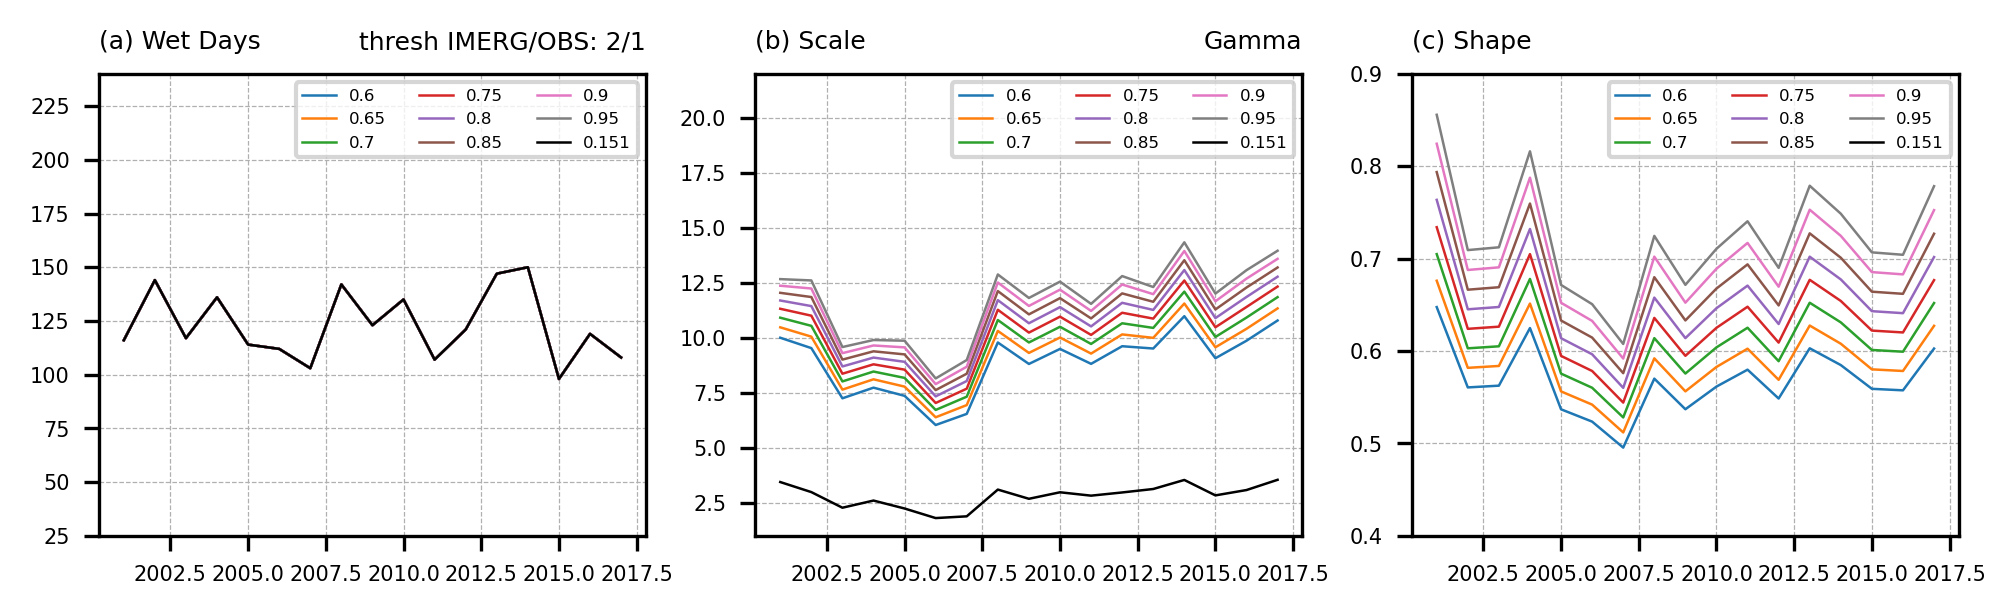

In [45]:
fig = plt.figure(figsize=(8,2),dpi=300)
gs = gridspec.GridSpec(1,3)

# ===========================================================================
ax1 = plt.subplot(gs[0,0])
for nn in range(len(gamma_var)):
    ax1.plot(IMERG_WEIBULL_YEAR[:,3], Nd_var[nn], linewidth=0.6, label=gamma_var[nn])
ax1.plot(IMERG_WEIBULL_YEAR[:,3], Nd_ref, c='k', linewidth=0.6, label=np.round(gamYd,3))

ax1.annotate('', xy=(2018, 125), xytext=(2021, 125),
            arrowprops=dict(arrowstyle='-', lw=2, color='red'))
ax1.annotate('', xy=(2018, 117), xytext=(2021, 117),
            arrowprops=dict(arrowstyle='-', lw=2, color='red'))

ax1.legend(fontsize=4, ncol=3)
ax1.xaxis.set_tick_params(labelsize=5)
ax1.yaxis.set_tick_params(labelsize=5)
ax1.set_ylim(25,240)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_title('(a) Wet Days', loc='left', fontsize=6)
ax1.set_title(f'thresh IMERG/OBS: {thresh}/{thresh_OBS}', loc='right', fontsize=6)

# ===========================================================================
ax1 = plt.subplot(gs[0,1])
for nn in range(len(gamma_var)):
    ax1.plot(IMERG_WEIBULL_YEAR[:,3], Cd_var[nn], linewidth=0.6, label=gamma_var[nn])
ax1.plot(IMERG_WEIBULL_YEAR[:,3], Cd_ref, c='k', linewidth=0.6, label=np.round(gamYd,3))

ax1.annotate('', xy=(2020, 20), xytext=(2020, 5),
            arrowprops=dict(arrowstyle='->', lw=2, color='red'))

ax1.legend(fontsize=4, ncol=3)
ax1.xaxis.set_tick_params(labelsize=5)
ax1.yaxis.set_tick_params(labelsize=5)
ax1.set_ylim(1,22)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_title('(b) Scale', loc='left', fontsize=6)
ax1.set_title('Gamma',loc='right',fontsize=6)

# ===========================================================================
ax1 = plt.subplot(gs[0,2])
for nn in range(len(gamma_var)):
    ax1.plot(IMERG_WEIBULL_YEAR[:,3], Wd_var[nn], linewidth=0.6, label=gamma_var[nn])
ax1.plot(IMERG_WEIBULL_YEAR[:,3], Wd_ref, c='k', linewidth=0.6, label=np.round(gamYd,3))

ax1.annotate('', xy=(2020, 0.85), xytext=(2020, 0.50),
            arrowprops=dict(arrowstyle='->', lw=2, color='red'))

ax1.legend(fontsize=4, ncol=3)
ax1.xaxis.set_tick_params(labelsize=5)
ax1.yaxis.set_tick_params(labelsize=5)
ax1.set_ylim(0.4,0.9)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_title('(c) Shape', loc='left', fontsize=6)

# ===========================================================================
ax1.set_facecolor('white')
fig.patch.set_alpha(0)

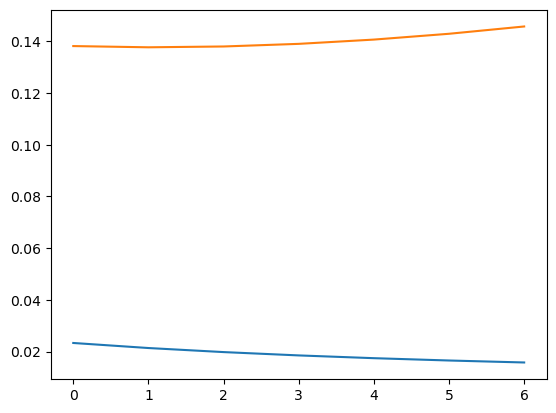

In [46]:
plt.plot(beta_shape)
plt.plot(gamma_shape)